# Plot Results
This notebook plots results from the network construction procedure, as well as DCOPF and UC models previously run. Data from AEMO's Market Management System Database Model (MMSDM) [1] is imported, allowing comparisons to be made between model and observed values for generator dispatch and interconnector flows.

A summary of the sections within this notebook is as follows:
1. Import packages, declare paths to files
2. Load MMSDM data
3. Load network data
    * Explore network data by plotting network elements, NEM zones, and demand allocations
    * Create an interactive map using Folium
4. Create class used to extract data from pickled Pyomo model results. Methods within this class will be used to extract and process data for different scenarios.
5. Instantiate scenario result objects
6. Manuscript plots:
    * compare observed aggregate dispatch with model dispatch for the different scenarios investigated
    * plot Voronoi tessellation:
        * plot figure showing dataset underlying the demand allocation procedure, the Voronoi tessellation, and final demand allocations.
    * create figure giving overview of the dataset (network features, distribution of generating assets, regional demand and power generation signals)
    * compare observed net aggregate interconnector flow with model flows for the different scenarios investigated.
7. Miscellaneous plots:
    * dispatch profiles from stations
    * plot of power-flow throughout network

## Import packages

In [1]:
import os
import re
import pickle

import math
import numpy as np
import pandas as pd
import geopandas as gp

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

import folium

Set text options for plots.

In [2]:
matplotlib.rcParams['font.family'] = ['sans-serif']
matplotlib.rcParams['font.serif'] = ['Helvetica']
# plt.rc('text', usetex=True)

## Paths to files

In [3]:
class DirectoryPaths(object):
    "Path to relevant directories"
    
    def __init__(self):
        # Core data directory
        self.data_dir = os.path.abspath(os.path.join(os.path.curdir, os.path.pardir, os.path.pardir, 'data'))

        # Network directory
        self.network_dir = os.path.abspath(os.path.join(os.path.curdir, os.path.pardir, '1_network'))

        # Generators directory
        self.gens_dir = os.path.abspath(os.path.join(os.path.curdir, os.path.pardir, '2_generators'))

        # Signals directory
        self.signals_dir = os.path.abspath(os.path.join(os.path.curdir, os.path.pardir, '3_load_and_dispatch_signals'))

        # DCOPF directory
        self.dcopf_dir = os.path.abspath(os.path.join(os.path.curdir, os.path.pardir, '4_DCOPF'))

        # UC directory
        self.uc_dir = os.path.abspath(os.path.join(os.path.curdir, os.path.pardir, '5_UC'))

        # Output path
        self.output_dir = os.path.abspath(os.path.join(os.path.curdir, 'output'))

paths = DirectoryPaths()

## Network Data
Import data relating to network elements.

In [4]:
class NetworkData(DirectoryPaths):
    "Load data used to construct network plots"
    
    def __init__(self):
        # Paths to directories
        DirectoryPaths.__init__(self)
        
        # Processed datasets
        # ------------------
        # Nodes
        self.df_n = pd.read_csv(os.path.join(self.network_dir, 'output', 'network_nodes.csv'), index_col='NODE_ID', dtype={'NEAREST_NODE':np.int32})

        # Edges
        self.df_e = pd.read_csv(os.path.join(self.network_dir, 'output', 'network_edges.csv'), index_col='LINE_ID')

        # HVDC links
        self.df_hvdc_i = pd.read_csv(os.path.join(self.network_dir, 'output', 'network_hvdc_links.csv'), index_col='HVDC_LINK_ID')

        # AC interconnectors
        self.df_ac_i = pd.read_csv(os.path.join(self.network_dir, 'output', 'network_ac_interconnector_links.csv'), index_col='INTERCONNECTOR_ID')

        # Power station - node assignments
        self.df_station_nodes = pd.read_csv(os.path.join(self.network_dir, 'output', 'network_power_stations-nodes.csv'), index_col='POWER_STATION_ID', dtype={'NEAREST_NODE':np.int32})

        # Generator data
        self.df_g = pd.read_csv(os.path.join(self.gens_dir, 'output', 'generators.csv'), index_col='DUID')

        # AEMO DUIDs - Geoscience Australia power station names - cross-reference table
        self.df_duid_stations = pd.read_csv(os.path.join(self.data_dir, 'cross_reference', 'DUID-GA-POWER_STATIONS.csv'), index_col='DUID')

        
        # ABS data
        # --------
        # State and territory boundaries in Australia
        self.gdf_states = gp.GeoDataFrame.from_file(os.path.join(self.data_dir, 'ABS', '1259030002_ste06aaust_shape', 'STE06aAUST.shp'))

        # Simplify geometry of state boundaries
        self.gdf_states['geometry'] = self.gdf_states['geometry'].simplify(tolerance=0.01)
        
        # SA2 areas
        with open(os.path.join(self.network_dir, 'output', 'gdf_SA2.pickle'), 'rb') as f: 
            self.gdf_SA2 = pickle.load(f)


        # Original Geoscience Australia dataframes (prior to processing)
        # --------------------------------------------------------------
        # Transmission lines
        self.gdf_lo = gp.read_file(os.path.join(self.network_dir, 'output', 'kml_to_geojson', 'lines', 'doc.geojson'))

        # Power stations
        self.gdf_po = gp.read_file(os.path.join(self.network_dir, 'output', 'kml_to_geojson', 'power_stations', 'doc.geojson'))

        # Substations
        self.gdf_so = gp.read_file(os.path.join(self.network_dir, 'output', 'kml_to_geojson', 'substations', 'doc.geojson'))


        # Geodataframes after network data processing
        # -------------------------------------------
        # NEM zones
        with open(os.path.join(self.network_dir, 'nem_zones', 'gdf_nem_zones.pickle'), 'rb') as f:
            self.gdf_nem_zones = pickle.load(f)

        # Nodes
        with open(os.path.join(self.network_dir,'output', 'gdf_n.pickle'), 'rb') as f:
            self.gdf_n = pickle.load(f)

        # Transmission lines
        with open(os.path.join(self.network_dir,'output', 'gdf_l.pickle'), 'rb') as f:
            self.gdf_l = pickle.load(f)

        # Power stations
        with open(os.path.join(self.network_dir,'output', 'gdf_p.pickle'), 'rb') as f:
            self.gdf_p = pickle.load(f)

        # Substations
        with open(os.path.join(self.network_dir,'output', 'gdf_s.pickle'), 'rb') as f:
            self.gdf_s = pickle.load(f)
            
        # Veronoi tessellation
        with open(os.path.join(self.network_dir,'output', 'gdf_vor.pickle'), 'rb') as f:
            self.gdf_vor = pickle.load(f)
            
        # Unary union of SA2 polygons
        with open(os.path.join(self.network_dir,'output', 'gdf_u.pickle'), 'rb') as f:
            self.gdf_u = pickle.load(f)
            
network_data = NetworkData()

## Network Plots

In [5]:
class NetworkPlots(NetworkData):
    "Plot data relating to network elements"
    
    def __init__(self):
        DirectoryPaths.__init__(self)
        NetworkData.__init__(self)
        
        
    def plot_all_network_elements(self):
        "Plot all elements (unfiltered) from Geoscience Australia datasets"
        
        plt.clf()
        # State boundaries
        ax = self.gdf_states.set_index('STATE_NAME').drop(['Other Territories']).plot(color='white', edgecolor='black', linewidth=0.5)

        # Transmission lines
        self.gdf_lo.plot(ax=ax, color='black', linewidth=0.5)

        # Substations
        self.gdf_so.plot(ax=ax, color='blue', markersize=0.7)

        # Power stations
        self.gdf_po.plot(ax=ax, color='red', markersize=0.7)

        # Format axes
        ax.set_xlim(110, 155)
        ax.set_axis_off()
        plt.legend(['Transmission lines', 'Substations', 'Power stations'], loc='lower left')
        plt.tight_layout()

        # Save figure
        plt.savefig(os.path.join(self.output_dir, 'figures', 'ga_data.pdf'), bbox_inches='tight')
        plt.show()
        
        
    def plot_filtered_network_elements_show_states(self):
        "Plot filtered network elements and show state boundaries"
        
        plt.clf()
        # Plot states
        ax = self.gdf_states.set_index('STATE_NAME').drop(['Other Territories']).plot(color='white', edgecolor='black', linewidth=0.5)

        # Plot connected AC and HVDC transmission lines
        mask = (self.gdf_l['CONNECTED'] == True) | (self.gdf_l['IS_HVDC'] == True)
        self.gdf_l.loc[mask, 'geometry'].plot(ax=ax, color='black', linewidth=0.3, alpha=0.7)

        # Plot all nodes
        mask = self.gdf_n['CONNECTED'] == True
        self.gdf_n[mask].plot(ax=ax, markersize=1.6, color='blue')

        # Plot generators
        mask = self.gdf_p['CONNECTED'] == True
        self.gdf_p[mask].plot(ax=ax, color='red', markersize=1.6)

        # Format axes
        plt.legend(['Transmission lines', 'Substations', 'Power stations'], loc='lower left')
        ax.set_xlim(110, 155)
        ax.set_axis_off()
        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, 'figures', 'nem_network.pdf'), bbox_inches='tight')
        plt.show()
       
        
    def plot_filtered_network_elements_show_NEM_zones(self):
        "Plot filtered network elements and show NEM zones"
        
        plt.clf()
        # NEM zones
        self.gdf_nem_zones['geometry'] = self.gdf_nem_zones['geometry'].simplify(tolerance=0.01)
        ax = self.gdf_nem_zones.plot(cmap='tab20c', alpha=0.7)

        # Plot connected AC and HVDC transmission lines
        mask = (self.gdf_l['CONNECTED'] == True) | (self.gdf_l['IS_HVDC'] == True)
        self.gdf_l.loc[mask, 'geometry'].plot(ax=ax, color='black', linewidth=0.3, alpha=0.7)

        # Nodes
        mask = self.gdf_n['CONNECTED'] == True
        self.gdf_n[mask].plot(ax=ax, markersize=2.5, color='blue')

        # Nodes at which generators are connected
        self.gdf_n.loc[self.df_g.NODE.astype(int)].plot(ax=ax, color='red', markersize=2.5)

        # Format axes
        fig = ax.get_figure()
        fig.subplots_adjust(left=0, bottom=0, right=1, top=1)
        plt.legend(['Transmission lines', 'Substations', 'Power stations'], loc='center left', fontsize=8)
        ax.set_xlim(129, 154)
        ax.set_axis_off()
        width = 5 * 0.8
        height = width*1.5
        fig.set_size_inches(width, height)

        # Save figure
        fig.savefig(os.path.join(self.output_dir, 'figures', 'network_elements_and_nem_zones.pdf'))
        plt.show()
        
        
    def plot_demand_allocation(self):
        "Plot proportion of regional demand allocated to each node"
        
        plt.clf()
        # State boundaries
        ax = self.gdf_states.set_index('STATE_NAME').drop(['Northern Territory', 'Other Territories', 'Western Australia']).plot(color='white', edgecolor='black', linewidth=0.5)

        # Proportion of regional demand allocated to each node
        self.gdf_n[['geometry', 'PROP_REG_D']].plot(ax=ax, color='blue', markersize=250*self.gdf_n['PROP_REG_D'], alpha=0.3)

        # Format axes
        ax.set_axis_off()
        ax.set_xlim(128,155)
        fig = ax.get_figure()
        fig.subplots_adjust(left=0.02, bottom=0, right=1, top=1)

        # Re-size figure
        width = 5 * 0.8
        height = width*1.5
        fig.set_size_inches(width, height)

        # Save figure
        fig.savefig(os.path.join(self.output_dir, 'figures', 'network_scaled_demand_allocation.pdf'))
        plt.show()
      
    
    def plot_dataset_construction_overview(self):
        "Plot filtered network elements and NEM state boundaries"
        
        plt.clf()
        # Plot NEM state boundaries
        ax = self.gdf_states.set_index('STATE_NAME').drop(['Other Territories', 'Western Australia', 'Northern Territory']).plot(color='white', edgecolor='black', linewidth=0.5)
        fig = ax.get_figure()

        # Plot transmission lines
        mask = (self.gdf_l['CONNECTED'] == True) | (self.gdf_l['IS_HVDC'] == True)
        self.gdf_l.loc[mask, 'geometry'].plot(ax=ax, color='black', linewidth=0.3, alpha=0.7)

        # Plot all nodes
        mask = self.gdf_n['CONNECTED'] == True
        self.gdf_n[mask].plot(ax=ax, markersize=1.6, color='blue')

        # Plot generators
        mask = self.gdf_p['CONNECTED'] == True
        self.gdf_p[mask].plot(ax=ax, color='red', markersize=1.6)

        # Format figure + axes
        fig.subplots_adjust(left=0, bottom=0, right=1, top=1)
        plt.legend(['Transmission lines', 'Substations', 'Power stations'], loc='center left', fontsize=8)
        ax.set_xlim(129, 154)
        ax.set_axis_off()
        fig.set_size_inches(2.8, 3.67)
        fig.savefig(os.path.join(self.output_dir, 'figures', 'dataset_construction_overview_network.pdf'))
        plt.show()
        
        
    def plot_NEM_zones_next_to_demand_allocations(self):
        "Plot network with NEM zones next to plot of demand allocations"
        
        # Adjusting aspect ratio for figure
        w = 1/math.cos(math.radians(60.0))

        plt.clf()
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

        # Demand
        # -------
        # State boundaries
        self.gdf_states.set_index('STATE_NAME').drop(['Northern Territory', 'Other Territories', 'Western Australia']).plot(color='white', edgecolor='black', linewidth=0.5, ax=ax2)

        # Proportion of regional demand allocated to each node
        self.gdf_n[['geometry', 'PROP_REG_D']].plot(ax=ax2, color='blue', markersize=250*self.gdf_n['PROP_REG_D'], alpha=0.3)

        # Format axes
        ax2.set_axis_off()
        ax2.set_xlim(128,155)

        
        # Zones
        # -----
        # NEM zones
        self.gdf_nem_zones['geometry'] = self.gdf_nem_zones['geometry'].simplify(tolerance=0.01)
        self.gdf_nem_zones.plot(cmap='tab20', alpha=0.7, ax=ax1)

        # Transmission lines
        mask = (self.gdf_l['CONNECTED'] == True) | (self.gdf_l['IS_HVDC'] == True)
        self.gdf_l.loc[mask, 'geometry'].plot(ax=ax1, color='black', linewidth=0.3, alpha=0.7)

        # Nodes
        mask = self.gdf_n['CONNECTED'] == True
        self.gdf_n[mask].plot(ax=ax1, markersize=2.5, color='blue')

        # Generators
        mask = self.gdf_p['CONNECTED'] == True
        self.gdf_p[mask].plot(ax=ax1, color='red', markersize=2.5)

        # Format axes
        ax1.legend(['Transmission lines', 'Substations', 'Power stations'], loc='center left', fontsize=8)
        ax1.set_xlim(129, 154)
        ax1.set_axis_off()
        width = 8.04208
        height = 5.95114
        fig.set_size_inches(width, height)

        # Save figure
        fig.savefig(os.path.join(self.output_dir, 'figures', 'nem_zones_and_demand_allocation.pdf'))
        plt.show()      

network_plots = NetworkPlots()

## Exploratory plots
### Network plots

#### Geoscience Australia datasets
##### All network elements

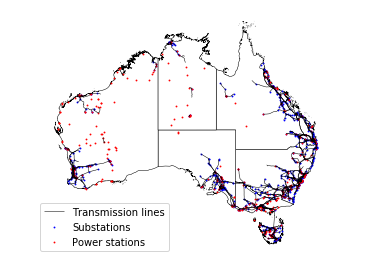

In [6]:
network_plots.plot_all_network_elements()

##### Filtered network elements

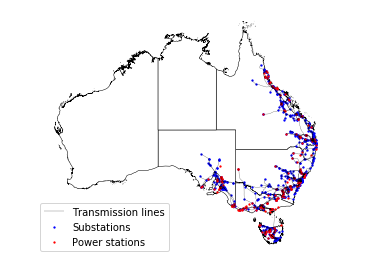

In [7]:
network_plots.plot_filtered_network_elements_show_states()

##### Filtered network with NEM zones

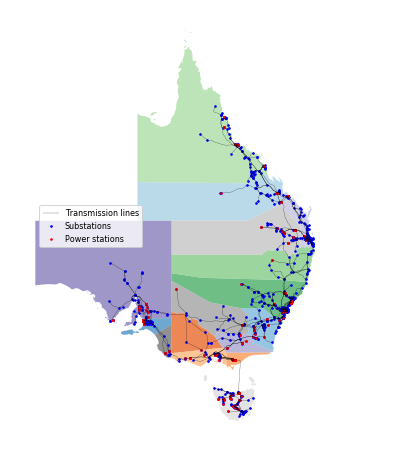

In [8]:
network_plots.plot_filtered_network_elements_show_NEM_zones()

##### Demand allocation
Plot geospatial distribution of demand. The size of each dot represents the proportion of NEM regional demand consumed at that node.

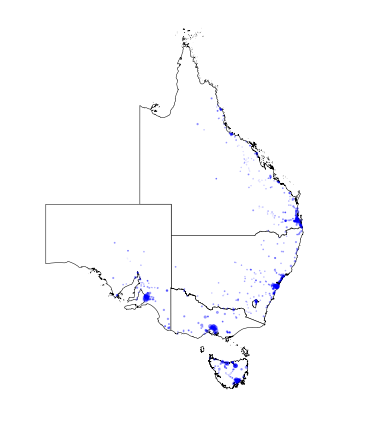

In [9]:
network_plots.plot_demand_allocation()

##### Filtered network elements within NEM states

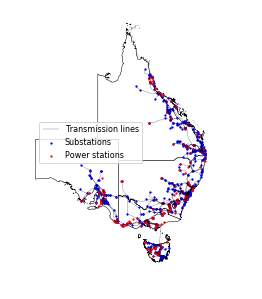

In [10]:
network_plots.plot_dataset_construction_overview()

##### Filtered network elements shown within NEM zones next to demand allocation map

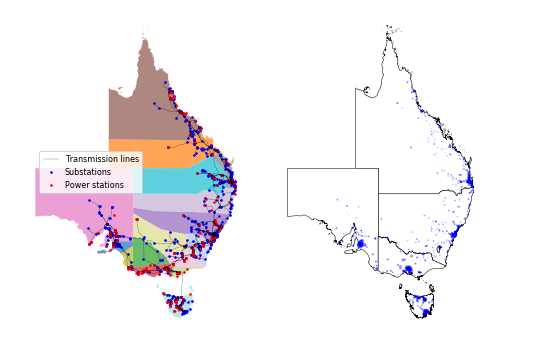

In [11]:
network_plots.plot_NEM_zones_next_to_demand_allocations()

### Interactive map using Folium

**Legend:**

| Marker / Line | Description |
| :------------- | :----------- |
| Blue line | Transmission line |
| Green marker | Network node |
| Orange marker | Connected network element not coincident with assigned node |
| Orange line | Indicates which node the connected network element has been assigned |
| Red marker | Disconnected network element |
| Red line | Indicates closest node to disconnected network element |

In [12]:
class InteractiveNetworkMap(NetworkData):
    """Create an interactive map showing network elements"""
    
    def __init__(self):
        # Network data
        NetworkData.__init__(self)
        
        # Instantiate folium map
        self.m = folium.Map(location=[-22, 132], tiles='Stamen Toner', zoom_start=4)
    
    
    def add_lines(self, gdf_l, colour):
        "Plot transmission lines"
        
        for index, line in gdf_l.iterrows():
            # Get lon-lat coordinates from simplified linestring object
            lons, lats = line['geometry'].xy[0], line['geometry'].xy[1]
            
            # Construct lat-lon pairs for plotting
            c = [i for i in zip(lats, lons)]
            
            # Popup text is name of line
            popup = ' : '.join(['l', str(index), line['name']])
            
            # Plot line
            folium.PolyLine(locations=c, popup=popup).add_to(self.m)
    
    
    def add_nodes(self, gdf_n, colour):
        "Plot network nodes"
        
        # Concatenate power station and substation records
        gdf_e = self.gdf_s.append(self.gdf_p)

        # Convert nearest node to type int
        gdf_e['NEAREST_NODE'] = gdf_e['NEAREST_NODE'].map(lambda x: int(x))

        # Get IDs of all connected elements
        df_conel = gdf_e.reset_index().groupby('NEAREST_NODE')[['index']].aggregate(lambda x: tuple(x))

        # Extract text for connected elements
        df_text = df_conel.apply(lambda x: [', '.join([' - '.join((i[0], i[1])) for i in zip(i, gdf_e.loc[i,'name'].values)]) for i in x], axis=1)

        # Reindex and convert to series
        df_text = df_text.reindex(gdf_n.index)['index']
        
        for index, n in gdf_n.iterrows():
            # If some elements are connected to a given node, extract them and construct a string
            # which will popup on the map
            if not pd.isnull(df_text.loc[index]):
                conel = df_text.loc[index]
            else:
                conel = ''

            # Popup text schema
            html = """
                <ol style="list-style-type:none">
                    <li>node_id : {0}</li>
                    <li>connected_elements : {1}</li>
                </ol>""".format(index, conel)

            iframe = folium.IFrame(html=html, width=300, height=200)
            popup = folium.Popup(iframe, max_width=500)

            # Coordinates of node
            lon, lat = gdf_n.loc[index, 'geometry'].x, gdf_n.loc[index, 'geometry'].y

            # Plot marker
            folium.CircleMarker(location=[lat, lon], radius=5, color='green', fill=True, popup=popup).add_to(self.m)
    
    
    def add_elements(self, df_e, colour):
        "Add network elements (substation and power station records)"
        
        # Combine substation and power station records
        gdf_e = self.gdf_s.append(self.gdf_p)
        
        # Plot substations and power stations that are not exactly coincident with a network node
        # Draw a line between these network elements and their assigned node
        for index, e in df_e.iterrows():
            lon, lat = e['geometry'].xy[0][0], e['geometry'].xy[1][0]
            popup = ' : '.join([index, gdf_e.loc[index, 'name']])

            # Plot point
            folium.CircleMarker(location=[lat, lon],
                                radius=5,
                                color=colour, fill=True,
                                popup=popup).add_to(self.m)  
            
            # Plot line between element and its assigned node
            node_lon, node_lat = self.gdf_n.loc[gdf_e.loc[index, 'NEAREST_NODE'], 'COORDINATES']
            folium.PolyLine(locations=[(lat, lon), (node_lat, node_lon)],
                            color=colour).add_to(self.m)
       
    
    def create_map(self, file_name):
        """Run class methods to create html map"""

        # Combine substation and power station records
        gdf_e = self.gdf_s.append(self.gdf_p)
        
        # Plot connected transmission lines
        mask = (self.gdf_l['CONNECTED'] == True) | (self.gdf_l['IS_HVDC'] == True)
        self.add_lines(self.gdf_l[mask], colour='blue')
        print('Lines plotted')
        
        # Plot connected nodes
        mask = self.gdf_n['CONNECTED'] == True
        self.add_nodes(self.gdf_n[mask], 'blue')
        print('Nodes plotted')

        # Plot connected network elements
        mask = (gdf_e['NEAREST_NODE_DISTANCE_KM'] > 0) & (gdf_e['CONNECTED'] == True)
        self.add_elements(gdf_e.loc[mask], 'orange')
        print('Connected network elements plotted')
        
        # Plot disconnected network elements
        mask = (gdf_e['NEAREST_NODE_DISTANCE_KM'] > 0) & (gdf_e['CONNECTED'] == False)
        self.add_elements(gdf_e.loc[mask], 'red')
        print('Disconnected network elements plotted')

        self.m.save(os.path.join(self.output_dir, 'maps', file_name))

#### Construct interactive map

In [13]:
interactive_map = InteractiveNetworkMap()
interactive_map.create_map('1_nem_connected.html')

Lines plotted
Nodes plotted
Connected network elements plotted
Disconnected network elements plotted


## Pyomo model results
Class used to extract data from pickled Pyomo model results.

In [14]:
class ModelData(DirectoryPaths):
    "Extract and parse data from Pyomo result files"
    
    def __init__(self):
        
        # Paths to relevant directories
        # -----------------------------
        DirectoryPaths.__init__(self)
        
        # Objects
        # -------           
        # Admittance matrix
        with open(os.path.join(self.dcopf_dir, 'output', 'df_Y.pickle'), 'rb') as f:
            self.df_Y = pickle.load(f)
        
        # Dataframes
        # ----------
        # AC interconnectors
        self.df_ac_i = pd.read_csv(os.path.join(self.network_dir, 'output', 'network_ac_interconnector_links.csv'), index_col='INTERCONNECTOR_ID')
        
        # HVDC interconnectors
        self.df_hvdc = pd.read_csv(os.path.join(self.network_dir, 'output', 'network_hvdc_links.csv'), index_col='HVDC_LINK_ID')

        # Generator information
        self.df_g = pd.read_csv(os.path.join(self.gens_dir, 'output', 'generators.csv'), index_col='DUID')

        # Observed DUID dispatch
        self.df_scada = pd.read_csv(os.path.join(self.signals_dir, 'output', 'signals_dispatch.csv'), index_col='SETTLEMENTDATE', parse_dates=['SETTLEMENTDATE'])
        
        # Regional load
        self.df_demand = pd.read_csv(os.path.join(self.signals_dir, 'output', 'signals_regional_load.csv'), index_col='SETTLEMENTDATE', parse_dates=['SETTLEMENTDATE'])
                
    @staticmethod
    def convert_to_int(row):
        "Convert to integer if possible, else return original input"
        
        try:
            x = int(row)
        except:
            x = row
        return x

    @staticmethod
    def get_aggregate_dispatch(series):
        "Get aggregate dispatch"
        
        # Trading interval duration
        interval = series.index[1] - series.index[0]
        interval_hrs = interval.seconds / 3600
        
        # Total dispatch
        return series.sum() * interval_hrs
    
    
    def get_observed_duid_dispatch_profiles(self, duid, t_range):
        "Get observed dispatch profiles for a specified time range"
        
        return self.df_scada.loc[t_range]
    
    
    def get_observed_duid_dispatch_profile(self, duid, t_range):
        "Get observed dispatch for given DUID for a specified time range"
        
        return self.df_scada.loc[t_range, duid]
    
    
    def get_observed_station_dispatch_profiles(self, t_range):
        "Get observed station dispatch profiles for a specified time range"
        
        return self.df_scada.reindex(t_range).T.join(self.df_g[['STATIONID']], how='left').groupby('STATIONID').sum().T
    
    
    def get_observed_station_dispatch_profile(self, station_id, t_range):
        "Get observed dispatch for given station for a specified time range"
        
        return self.get_observed_station_dispatch_profiles(t_range).loc[t_range, station_id]
    
    
    def get_observed_station_dispatch_aggregate(self, station_id, t_range):
        "Get aggregate dispatch for a station for a specified time range"
        
        # Dispatch profile for station
        series = self.get_observed_station_dispatch_profile(station_id, t_range)
        
        return self.get_aggregate_dispatch(series)
    
    
    def get_observed_interconnector_flows(self, t_range):
        "Get observed flows over all interconnector for specified time interval"
        
        # Read data
        df = pd.read_csv(os.path.join(self.data_dir, 'AEMO', 'MMSDM', 'PUBLIC_DVD_TRADINGINTERCONNECT_201706010000.CSV'), engine='python', skiprows=1, skipfooter=1, parse_dates=['SETTLEMENTDATE'])
        
        # Apply pivot s.t. index = time stamp, columns = interconnector IDs, values = MW flow over interconnector
        return df.pivot(index='SETTLEMENTDATE', columns='INTERCONNECTORID', values='MWFLOW').loc[t_range]
    
    
    def get_observed_interconnector_flow(self, interconnector_id, t_range):
        "Get observed flow over given interconnector for specified time interval"
        
        return self.get_observed_interconnector_flows[interconnector_id]
    
    
    def get_interconnector_ids(self):
        "Return list of interconnector IDs"
        
        # AC interconnector IDs
        intercon_ids = list(self.df_ac_i.index)
        
        # Include HVDC interconnector IDs
        df_hvdc_index = self.df_hvdc.index
        
        # Drop Directlink HVDC line (technically not an interconnector)
        df_hvdc_index = df_hvdc_index.drop('DIRECTLINK')
        
        # Combine HVDC and AC interconnector IDs
        intercon_ids.extend(list(df_hvdc_index))
        
        return list(set(intercon_ids))
    
        

class DCOPFResults(ModelData):
    "Perform analysis on linear DCOPF model results"
    
    def __init__(self, results_path):
        ModelData.__init__(self)

        self.results_path = results_path
        
        # Load results
        with open(self.results_path, 'rb') as f: 
            self.results = pickle.load(f)
    
    
    def parse_dcopf_results(self):
        "Parse DCOPF model results"
        
        # Place DCOPF results into a dataframe
        t_keys = list(self.results.keys())
        
        for i, t in enumerate(t_keys):
            if i == 0:
                df = pd.DataFrame(data=self.results[t]['Solution'][0]['Variable'])
            else:
                df = df.append(pd.DataFrame(data=self.results[t]['Solution'][0]['Variable']))
        df.index = t_keys
        df = df.T

        # Extract set and variable names
        df['SET_NAME'] = df.apply(lambda x: re.findall('(.+)\[', x.name)[0], axis=1)
        df['VAR_NAME'] = df.apply(lambda x: re.findall('\[(.+)\]', x.name)[0], axis=1)
        
        # Remove single quotations from VAR_NAME if exists
        df['VAR_NAME'] = df.apply(lambda x: x['VAR_NAME'].replace("'", ""), axis=1)

        # Convert time index to type int

        df['VAR_NAME'] = df['VAR_NAME'].map(self.convert_to_int)

        return df
    
    
    def get_duration_between_intervals(self):
        "Get duration between adjacent time intervals"

        # Time index
        t_keys = list(self.results.keys())

        # Interval length in datetime format
        t_delta = (list(self.results.keys())[1] - list(self.results.keys())[0])

        # Duration in hours
        t_delta_hrs = t_delta.seconds / 3600

        return t_delta, t_delta_hrs         
        
        
    def get_model_interconnector_flows(self):
        "Get interconnector flows"
        
        # Load DCOPF DataFrame
        df = self.parse_dcopf_results()
        
        # Test if reduced network is loaded
        is_reduced = ~ df['SET_NAME'].str.contains('v').any()
        
        # If using reduced network
        if is_reduced:
            # Retrieve AC and HVDC link flows
            mask = df['SET_NAME'].isin(['a', 'h'])
            df_flow = df[mask].set_index('VAR_NAME').drop('SET_NAME', axis=1)

            # Map between link names and interconnector IDs
            intercon_ids = {'NNS,SWQ': 'NSW1-QLD1', 'MEL,SESA': 'V-SA', 'NNS,SEQ': 'N-Q-MNSP1', 'NVIC,CAN': 'VIC1-NSW1',
                            'NVIC,SWNSW': 'VIC1-NSW1', 'CVIC,SWNSW': 'VIC1-NSW1', 'T-V-MNSP1': 'T-V-MNSP1', 'V-S-MNSP1': 'V-S-MNSP1'}
            s_intercon_id = pd.Series(intercon_ids)
            s_intercon_id.name = 'INTERCONNECTOR_ID'

            # Join interconnector IDs to link flow DataFrame, groupby interconnector ID and sum
            return df_flow.join(s_intercon_id, how='left').dropna().groupby('INTERCONNECTOR_ID').sum().T
        
        else:
            # Voltage angles for each time period
            mask = df['SET_NAME'] == 'v'
            df_ang = df[mask].set_index('VAR_NAME').drop('SET_NAME', axis=1)

            # AC flow for each time period
            def get_ac_flow(row, df_ang):
                f = row['FROM_NODE']
                t = row['TO_NODE']
                return 100 * np.imag(self.df_Y.loc[f, t]) * (df_ang.loc[f] - df_ang.loc[t])
            # Flow over each link constituting an AC interconnector
            df_ac_flow = self.df_ac_i.apply(get_ac_flow, args=(df_ang,), axis=1)

            # Aggregate interconnector flow - sum flows if more than one link makes up an interconnector
            df_ac_i_flow = df_ac_flow.groupby(df_ac_flow.index).sum()

            # HVDC flow
            mask = df['SET_NAME'] == 'h'
            df_hvdc_flow = df[mask].set_index('VAR_NAME').drop('SET_NAME', axis=1)
            df_hvdc_flow.columns = pd.to_datetime(df_hvdc_flow.columns)
            
            # Drop Directlink (techinically not an interconnector)
            df_hvdc_flow = df_hvdc_flow.drop('DIRECTLINK')

            # Combine AC and HVDC flows
            return pd.concat([df_ac_i_flow, df_hvdc_flow]).T
           
            
    def get_model_interconnector_flow(self, interconnector_id):
        "Get flow for specified interconnector"
        
        # Get flows for all interconnectors
        df = self.get_model_interconnector_flows()
        
        # Return series for specified interconnector
        return df[interconnector_id]
    
    
    def get_model_duid_dispatch_profiles(self):
        "Get DUID dispatch profiles"
        
        # Model results
        df = self.parse_dcopf_results()
        
        # Only consider power output variables
        mask = df['SET_NAME'] == 'p'
        
        # Columns = DUIDs, index = timestamps, values = power output
        return df[mask].set_index('VAR_NAME').drop('SET_NAME', axis=1).T


    def get_model_duid_dispatch_profile(self, duid):
        "Get dispatch profile for a given DUID"

        return self.get_model_duid_dispatch_profiles()[duid]
    
    
    def get_model_station_dispatch_profiles(self):
        "Get aggregate station dispatch profiles"
        
        # DUID dispatch profiles 
        df = self.get_model_duid_dispatch_profiles()
        
        # Add station ID, then groupby station ID and sum
        return df.T.join(self.df_g[['STATIONID']], how='left').groupby('STATIONID').sum().T


    def get_model_station_dispatch_profile(self, station_id):
        "Get dispatch profile for a given station"

        return self.get_model_station_dispatch_profiles()[station_id]


    def get_model_station_dispatch_aggregate(self, station_id):
        "Get aggregate dispatch for a specified station"

        # Dispatch profile for station
        series = self.get_model_station_dispatch_profile(station_id)

        return self.get_aggregate_dispatch(series)
    
    
    def get_time_index(self):
        "Get time stamps"
        
        return self.get_model_duid_dispatch_profiles().index
    
    
    def get_station_ids(self):
        "Get list of station IDs"

        return list(self.get_model_station_dispatch_profiles().columns)
    
    
    def get_sorted_stations(self):
        "Get list of station IDs sorted by registered capacity"
        
        # Station dispatch profiles
        df = self.get_model_duid_dispatch_profiles()
        
        return list(df.T.join(self.df_g[['REG_CAP', 'STATIONID']], how='left').reset_index().groupby('STATIONID')['REG_CAP'].sum().sort_values(ascending=False).index)
    
    
    def compare_model_interconnector_flows(self):
        "Compare aggregate flow over interconnectors"
        
        # Model time stamps
        t_index = self.get_time_index()
        
        # Aggregate model interconnector flows
        _, hrs = self.get_duration_between_intervals()
        s_model = self.get_model_interconnector_flows().sum() * hrs
        s_model.name = 'model'

        # Observed flows
        s_observed = self.get_observed_interconnector_flows(t_index).sum() * hrs
        s_observed.name = 'observed'

        # Compare model and observed flows in single dataframe 
        return pd.concat([s_model, s_observed], axis=1)
    
    
    def compare_model_interconnector_flow_proportions(self):
        "Compare proportion of net flow over interconnectors linking VIC - SA, and NSW - QLD"
                
        # Model and observered interconnector flows
        df = self.compare_model_interconnector_flows()
    
        # Only one path for power flow between TAS1-VIC1 and only one interconnector defined for VIC1-NSW1. Drop these.
        df.drop(['T-V-MNSP1', 'VIC1-NSW1'], inplace=True)

        # Assign ID to differentiate between NSW-QLD and V-SA links
        df['category'] = df.apply(lambda x: x.name[0], axis=1)

        # Compute total flow between NSW-QLD and V-SA
        total_flow = df.groupby('category').sum()

        # Get proportion of total flow over each interconnector
        return df.apply(lambda x: x[['model', 'observed']] / total_flow.loc[x['category']], axis=1)
    

    
class UCResults(ModelData):
    "Perform analysis on UC model with temporal constraints"
    
    def __init__(self, results_path):
        ModelData.__init__(self)
   
        self.results_path = results_path
        
        # Load results
        with open(self.results_path, 'rb') as f: 
            self.results = pickle.load(f)

            
    def parse_uc_results(self):
        "Parse UC model results"
        
        # Energy output (MWh)
        df_e_output = self.results['df_e_output']

        # Timestamps
        t_stamps = df_e_output.index

        # Time indices in UC model are integers (1,2,3). Dictionary maps indices to timestamps.
        t_stamp_dict = dict([(k[0]+1, k[1]) for k in enumerate(df_e_output.index)])

        # Duration between timestamps
        t_delta = t_stamps[1] - t_stamps[0]
        t_delta_hrs = t_delta.seconds / 3600

        # Dataframe with UC model variable results
        df_uc = pd.DataFrame(data=self.results['Solution'][0]['Variable']).T
        df_uc['SET_NAME'] = df_uc.apply(lambda x: re.findall('(.+)\[', x.name), axis=1)

        # Drop dummy variable indices for now
        mask = df_uc.index.str.startswith('x1_dummy') | df_uc.index.str.startswith('x2_dummy')
        df_uc = df_uc[~mask]

        # Split index into components
        df_uc['VAR_NAME'] = df_uc.apply(lambda x: re.findall('\[(.+)\,', x.name)[0], axis=1)
        df_uc['T_INDEX'] = df_uc.apply(lambda x: re.findall('\,(\w+)\]', x.name)[0], axis=1)

        # Convert time index to type int
        df_uc['VAR_NAME'] = df_uc['VAR_NAME'].map(self.convert_to_int)

        # Convert time index into timestamp
        df_uc['T_STAMP'] = df_uc['T_INDEX'].map(lambda x: t_stamp_dict[int(x)])

        # Remove quotations around variable names if they exist
        df_uc['VAR_NAME'] = df_uc['VAR_NAME'].map(lambda x: x.replace("'",""))
        
        return df_uc
    
    
    def get_duration_between_intervals(self):
        "Get duration between adjacent time intervals"

        # Interval length in datetime format
        t_delta = self.results['T dict'][2] - self.results['T dict'][1]

        # Duration in hours
        t_delta_hrs = t_delta.seconds / 3600

        return t_delta, t_delta_hrs        
    
    
    def get_model_interconnector_flows(self):
        "Get interconnector flows"
        
        # Load DCOPF DataFrame
        df = self.parse_uc_results()
               
        # Retrieve AC and HVDC link flows
        mask = df['SET_NAME'].isin(['p_ac', 'p_hvdc'])
        df_flow = df[mask].set_index('VAR_NAME').drop('SET_NAME', axis=1)

        # Map between link names and interconnector IDs
        intercon_ids = {'NNS,SWQ': 'NSW1-QLD1', 'MEL,SESA': 'V-SA', 'NNS,SEQ': 'N-Q-MNSP1', 'NVIC,CAN': 'VIC1-NSW1',
                        'NVIC,SWNSW': 'VIC1-NSW1', 'CVIC,SWNSW': 'VIC1-NSW1', 'T-V-MNSP1': 'T-V-MNSP1', 'V-S-MNSP1': 'V-S-MNSP1'}
        s_intercon_id = pd.Series(intercon_ids)
        s_intercon_id.name = 'INTERCONNECTOR_ID'

        # Join interconnector IDs to link flow DataFrame, groupby interconnector ID and sum
        return df_flow.join(s_intercon_id, how='left').dropna().groupby('INTERCONNECTOR_ID').sum().T
       
        
    def get_model_interconnector_flow(self, interconnector_id):
        "Get flow over specified interconnector"
        
        return self.get_model_interconnector_flows()[interconnector_id]
    
    
    def compare_model_interconnector_flows(self):
        "Compare aggregate flow over interconnectors"
        
        # Model time stamps
        t_index = self.get_time_index()
        
        # Aggregate model interconnector flows
        _, hrs = self.get_duration_between_intervals()
        s_model = self.get_model_interconnector_flows().sum() * hrs
        s_model.name = 'model'

        # Observed flows
        s_observed = self.get_observed_interconnector_flows(t_index).sum() * hrs
        s_observed.name = 'observed'

        # Compare model and observed flows in single dataframe 
        return pd.concat([s_model, s_observed], axis=1)

    
    def get_model_duid_dispatch_profiles(self):
        "Get dispatch profile for all DUIDs"

        # Load UC model results
        df = self.parse_uc_results()

        # Only consider power output
        mask = df['SET_NAME'] == 'p'
        
        # Pivot s.t. index is time stamp, column names are DUIDs, values are power output
        return df[mask].pivot(index='T_STAMP', columns='VAR_NAME', values='Value')
    
    
    def get_model_duid_dispatch_profile(self, duid):
        "Get dispatch profile for a specified DUID"
        
        return self.get_model_duid_dispatch_profiles()[duid]
        
    
    def get_model_station_dispatch_profiles(self):
        "Get station dispatch profiles"
        
        df = self.results['df_p_hat']
        
        return df.T.join(self.df_g[['STATIONID']]).groupby('STATIONID').sum().T
    
    
    def get_model_station_dispatch_profile(self, station_id):
        "Get dispatch profile for a given station"
        
        return self.get_model_station_dispatch_profiles()[station_id]
    
    
    def get_model_station_dispatch_aggregate(self, station_id):
        "Get aggregate dispatch for a specified station"

        # Dispatch profile for station
        series = self.get_model_station_dispatch_profile(station_id)

        return self.get_aggregate_dispatch(series)
        
        
    def get_station_ids(self):
        "Return list of station IDs"    
        
        return list(self.get_model_station_dispatch_profiles().columns)
    
    
    def get_duids(self):
        "Return list of DUIDs"
        
        return list(self.get_model_duid_dispatch_profiles().columns)
    
    
    def get_time_index(self):
        "Get time stamps for model results"
        
        return self.get_model_station_dispatch_profiles().index
    
    
    def get_sorted_stations(self):
        "Get list of stations sorted by registered capacity"
        
        # DUID dispatch profiles
        df = self.get_model_duid_dispatch_profiles()
        
        # Join registered capacity and station ID, groupby station ID, sum over registered capacities, sort by aggregate station capacity
        return list(df.T.join(self.df_g[['REG_CAP', 'STATIONID']], how='left').reset_index().groupby('STATIONID')['REG_CAP'].sum().sort_values(ascending=False).index)

## Model results
Instatiate classes used to extract model results.

In [15]:
# Result file paths
# -----------------
# Full network
dcopf_full_network_fixed_gen_path = os.path.join(paths.dcopf_dir, 'output', 'DCOPF_full_network_fixed_gen_from_2017-06-01_00-30-00_to_2017-06-02_00-00-00.pickle')
dcopf_full_network_fixed_hydro_path = os.path.join(paths.dcopf_dir, 'output', 'DCOPF_full_network_fixed_hydro_from_2017-06-01_00-30-00_to_2017-06-02_00-00-00.pickle')
dcopf_full_network_free_gen_path = os.path.join(paths.dcopf_dir, 'output', 'DCOPF_full_network_free_gen_from_2017-06-01_00-30-00_to_2017-06-02_00-00-00.pickle')
dcopf_full_network_min_flow_dev_and_gen_cost_path = os.path.join(paths.dcopf_dir, 'output', 'DCOPF_full_network_min_flow_dev_and_gen_cost_from_2017-06-01_00-30-00_to_2017-06-02_00-00-00.pickle')
dcopf_full_network_flow_gen_dev_min_path = os.path.join(paths.dcopf_dir, 'output', 'DCOPF_full_network_flow_gen_dev_min_from_2017-06-01_00-30-00_to_2017-06-02_00-00-00.pickle')

# Reduced network
dcopf_reduced_network_fixed_gen_path = os.path.join(paths.dcopf_dir, 'output', 'DCOPF_reduced_network_fixed_gen_from_2017-06-01_00-30-00_to_2017-06-02_00-00-00.pickle')
dcopf_reduced_network_fixed_hydro_path = os.path.join(paths.dcopf_dir, 'output', 'DCOPF_reduced_network_fixed_hydro_from_2017-06-01_00-30-00_to_2017-06-02_00-00-00.pickle')
dcopf_reduced_network_free_gen_path = os.path.join(paths.dcopf_dir, 'output', 'DCOPF_reduced_network_free_gen_from_2017-06-01_00-30-00_to_2017-06-02_00-00-00.pickle')
dcopf_reduced_network_min_flow_dev_and_gen_cost_path = os.path.join(paths.dcopf_dir, 'output', 'DCOPF_reduced_network_min_flow_dev_and_gen_cost_from_2017-06-01_00-30-00_to_2017-06-02_00-00-00.pickle')
dcopf_reduced_network_flow_gen_dev_min_path = os.path.join(paths.dcopf_dir, 'output', 'DCOPF_reduced_network_flow_gen_dev_min_from_2017-06-01_00-30-00_to_2017-06-02_00-00-00.pickle')


# Non-linear UC model with temporal constraints
uc_results_path = os.path.join(paths.uc_dir, 'output', 'uc_results.pickle')


# Linear DCOPF model results
# --------------------------
# Full network
dcopf_full_network_fixed_gen = DCOPFResults(dcopf_full_network_fixed_gen_path)
dcopf_full_network_fixed_hydro = DCOPFResults(dcopf_full_network_fixed_hydro_path)
dcopf_full_network_free_gen = DCOPFResults(dcopf_full_network_free_gen_path)
dcopf_full_network_min_flow_dev_and_gen_cost = DCOPFResults(dcopf_full_network_min_flow_dev_and_gen_cost_path)
dcopf_full_network_flow_gen_dev_min = DCOPFResults(dcopf_full_network_flow_gen_dev_min_path)


# Reduced network
dcopf_reduced_network_fixed_gen = DCOPFResults(dcopf_reduced_network_fixed_gen_path)
dcopf_reduced_network_fixed_hydro = DCOPFResults(dcopf_reduced_network_fixed_hydro_path)
dcopf_reduced_network_free_gen = DCOPFResults(dcopf_reduced_network_free_gen_path)
dcopf_reduced_network_min_flow_dev_and_gen_cost = DCOPFResults(dcopf_reduced_network_min_flow_dev_and_gen_cost_path)
dcopf_reduced_network_flow_gen_dev_min = DCOPFResults(dcopf_reduced_network_flow_gen_dev_min_path)


# Non-linear UC model results
# ---------------------------
uc = UCResults(uc_results_path)


# Model data parent class
# -----------------------
model_data = ModelData()

# Timestamps used in model
t_index = dcopf_full_network_free_gen.get_time_index()

## Manuscript plots
### Aggregate dispatch

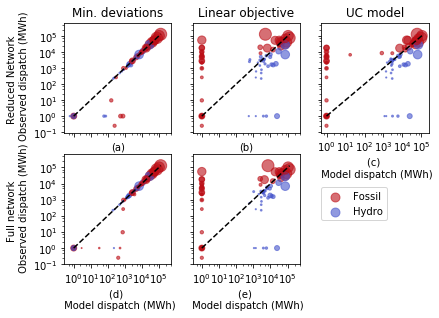

In [16]:
def agg_stations(series):
    "Aggregate station information"    
    return pd.Series({'FUEL_CAT': list(series['FUEL_CAT'])[0], 'REG_CAP': series['REG_CAP'].sum()})

# Aggregate registered capacity for stations and fuel type
stations = network_data.df_g.groupby('STATIONID')[['FUEL_CAT', 'REG_CAP']].agg(agg_stations)

# Colours assigned to generators with different fuel types
col_gen = {'Fossil': '#bc0f17', 'Hydro': '#4756cc'}

# Model time interval
t = dcopf_full_network_free_gen.get_time_index()

# Observed dispatch
obs_dispatch = model_data.get_observed_station_dispatch_profiles(t).sum()

# If output is zero, set = 1 (so can be plotted on log-log scale)
mask = obs_dispatch == 0
obs_dispatch = obs_dispatch.replace(obs_dispatch[mask], 1)

# Result objects to plot
res_objs = [('ax4', dcopf_full_network_flow_gen_dev_min, 4), ('ax5', dcopf_full_network_free_gen, 5),
            ('ax1', dcopf_reduced_network_flow_gen_dev_min, 1), ('ax2', dcopf_reduced_network_free_gen, 2), ('ax3', uc, 3)]

fig = plt.figure()
axes = dict()
for ax_name, res_obj, pos in res_objs:

    # Model dispatch
    mod_dispatch = res_obj.get_model_station_dispatch_profiles().sum()

    # Model generators
    mod_gens = res_obj.get_model_station_dispatch_profiles().columns

    # If output is zero, set = 1 (so can be plotted on log-log scale)
    mask = mod_dispatch == 0
    mod_dispatch = mod_dispatch.replace(mod_dispatch[mask], 1)

    
    if ax_name == 'ax2':
        ax = plt.subplot(int('23{0}'.format(pos)), sharex=axes['ax5'], sharey=axes['ax1'])
        plt.setp(ax.get_xticklabels(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
        plt.title('Linear objective')
        
    elif ax_name == 'ax1':
        ax = plt.subplot(int('23{0}'.format(pos)), sharex=axes['ax4'])
        plt.setp(ax.get_xticklabels(), visible=False)
        plt.title('Min. deviations')
        
    elif ax_name == 'ax3':
        ax = plt.subplot(int('23{0}'.format(pos)), sharey=axes['ax1'])
        plt.setp(ax.get_yticklabels(), visible=False)
        plt.title('UC model')
        
    elif ax_name == 'ax5':
        ax = plt.subplot(int('23{0}'.format(pos)), sharey=axes['ax4'])
        plt.setp(ax.get_yticklabels(), visible=False)
        
    else:
        ax = plt.subplot(int('23{0}'.format(pos)))
       
    plt.scatter(x=list(mod_dispatch), y=list(obs_dispatch.reindex(mod_dispatch.index)),
                     c=list(stations.loc[mod_dispatch.index, 'FUEL_CAT'].map(lambda x: col_gen[x])),
                     s=list(stations.loc[mod_dispatch.index, 'REG_CAP'] / 20), alpha=0.6)

    # Max and min dispatch values
    max_val = max(max(mod_dispatch), max(obs_dispatch[mod_gens]))
    min_val = min(min(mod_dispatch), min(obs_dispatch[mod_gens]))

    # Add dashed black line based on max and min values
    plt.plot([1, max_val], [1, max_val], 'k--')
    
    # Create log-log scale
    plt.loglog()
    
    # Major ticks
    locmaj = ticker.LogLocator(base=10, numticks=7) 
    ax.xaxis.set_major_locator(locmaj)
    ax.yaxis.set_major_locator(locmaj)
    
    # Minor ticks
    locmin = ticker.LogLocator(base=10.0, subs=(0.25, 0.5, 0.75), numticks=7)
    ax.xaxis.set_minor_locator(locmin)
    ax.xaxis.set_minor_formatter(ticker.NullFormatter())
    
    ax.yaxis.set_minor_locator(locmin)
    ax.yaxis.set_minor_formatter(ticker.NullFormatter())
    
    axes[ax_name] = ax

# Name axes
axes['ax1'].set_ylabel('Reduced Network \n Observed dispatch (MWh)')
axes['ax1'].set_xlabel('(a)')

axes['ax2'].set_xlabel('(b)')

axes['ax3'].set_xlabel('(c) \n Model dispatch (MWh)')

axes['ax4'].set_ylabel('Full network \n Observed dispatch (MWh)')
axes['ax4'].set_xlabel('(d) \n Model dispatch (MWh)')

axes['ax5'].set_xlabel('(e) \n Model dispatch (MWh)')


# Create legend
# -------------
# Dummy points to make dots same size
pt_fossil = axes['ax5'].scatter(10, 10, c=col_gen['Fossil'], alpha=0.6, s=80, label='Fossil')
pt_hydro = axes['ax5'].scatter(10, 10, c=col_gen['Hydro'], alpha=0.6, s=80, label='Hydro')

# Create legend
axes['ax5'].legend(bbox_to_anchor=(1.2, 0.7), loc=2, borderaxespad=0.)

# Remove dummy points
pt_fossil.remove()
pt_hydro.remove()

# Set figure size
width = 5.95114
height = width / 1.4
fig.set_size_inches(width, height)

# Adjust figure
fig.subplots_adjust(left=0.13, bottom=0.14, right=0.98, top=0.93)

# Save figure
fig.savefig(os.path.join(paths.output_dir, 'figures', 'aggregate_dispatch_scenarios.pdf'))  

## Voronoi tessellation
Use connected network nodes as seeds. A Veronoi tessellation is used to estimate the area that each node serves demand to.

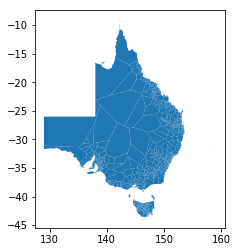

In [17]:
# Buffer Veronoi polygons
gdf_vpb = network_data.gdf_vor.copy()
gdf_vpb['geometry'] = gdf_vpb.buffer(0.0001)

# Buffer unary union polygons
gdf_ub = network_data.gdf_u.copy()
gdf_ub['geometry'] = gdf_ub.buffer(0.0001)

# Find overlay with SA2 polygons
gdf_o = gp.overlay(gdf_vpb, gdf_ub, how='intersection')
gdf_o.plot()

### Demand allocation

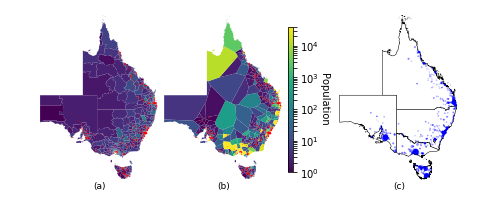

In [18]:
# Compute log of SA2 area population
gdf_SA2_c = network_data.gdf_SA2.copy()

# Dissolve polygons by node ID
gdf_od = gdf_o.dissolve(by='NODE_ID')

# Min max plotting colors
vmin, vmax = 1, 40000

fig = plt.figure()

# SA2 Areas
# ---------
ax1 = plt.axes([0, 0.04, 0.3, 1])
network_data.gdf_SA2.plot(column='Population_2015', vmin=vmin, vmax=vmax, ax=ax1)

mask = network_data.gdf_n['CONNECTED'] == True
network_data.gdf_n[mask].plot(markersize=0.01, color='red', ax=ax1)

ax1.set_xlim(128, 155)
ax1.set_ylim(-44, -9)
ax1.set_aspect('equal')
ax1.set_axis_off()


# Voronoi tessellation
# --------------------
ax2 = plt.axes([0.29,  0.04, 0.3, 1])

# Voronoi tessellation with nodes
gdf_od.plot(column='population', vmin=vmin, vmax=vmax, ax=ax2)

mask = network_data.gdf_n['CONNECTED'] == True
network_data.gdf_n[mask].plot(markersize=0.01, color='red', ax=ax2)

ax2.set_xlim(128, 155)
ax2.set_ylim(-44, -9)
ax2.set_aspect('equal')
ax2.set_axis_off()


# Colorbar
# --------
# Get first axis figure
cax = plt.axes([0.59, 0.155, 0.012, 0.75])

# Add colorbar
sm = plt.cm.ScalarMappable(norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax))
sm._A = []
cbar = plt.colorbar(sm, cax=cax, label='Population')
cbar.set_label('Population', rotation=270, labelpad=10)


# Allocation as proportion of regional demand
# -------------------------------------------
ax3 = plt.axes([0.7, 0.04, 0.3, 1])

# States
network_data.gdf_states.set_index('STATE_NAME').drop(['Northern Territory', 'Other Territories', 'Western Australia']).plot(ax=ax3, color='white', edgecolor='black', linewidth=0.5)

# Demand allocations
network_data.gdf_n[mask].plot(ax=ax3, color='blue', markersize=250*network_data.gdf_n.loc[mask, 'PROP_REG_D'], alpha=0.3)

ax3.set_xlim(128, 155)
ax3.set_ylim(-44, -9)
ax3.set_aspect('equal')
ax3.set_axis_off()

ax1.text(0.5, -0.05, "(a)", size=12, ha="center", transform=ax1.transAxes, fontsize=9)
ax2.text(0.5, -0.05, "(b)", size=12, ha="center", transform=ax2.transAxes, fontsize=9)
ax3.text(0.5, -0.05, "(c)", size=12, ha="center", transform=ax3.transAxes, fontsize=9)

# Re-size figure
width = 5.94114
height = 5.94114 / 2.2

fig.set_size_inches(width, height)
fig.subplots_adjust(left=0, bottom=0, right=1, top=0.5)

# Save figure
fig.savefig(os.path.join(os.path.join(paths.output_dir, 'figures', 'demand_allocation.pdf')))

### Dataset overview figure

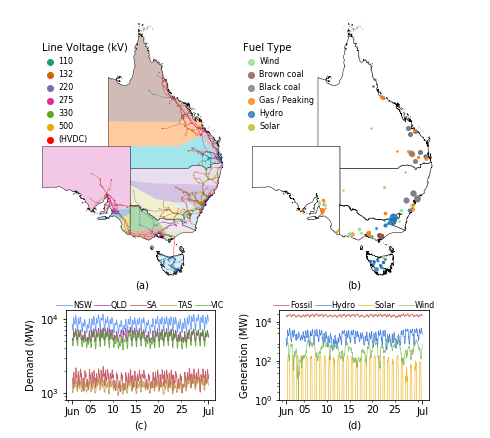

In [19]:
fig = plt.figure()

# Network edges subplot
# ---------------------
ax1 = plt.axes([0.01, 0.35, 0.5, 0.65])
colours = cm.Dark2.colors

# State boundaries
network_data.gdf_states.set_index('STATE_NAME').drop(['Northern Territory', 'Other Territories', 'Western Australia']).plot(ax=ax1, color='white', edgecolor='black', linewidth=0.5)

# Plot nodes
mask = network_data.gdf_n['CONNECTED'] == True
network_data.gdf_n[mask].plot(ax=ax1, color='blue', markersize=0.1, alpha=0.6)

# Create list of voltage levels for AC links
mask = network_data.gdf_l['CONNECTED'] == True
voltage_levels = network_data.gdf_l.loc[mask, 'CAPACITYKV'].unique()
voltage_levels.sort()

# Plot AC lines
mask = network_data.gdf_l['CONNECTED'] == True
df1 = network_data.gdf_l[mask].copy()
voltage_level_index = {j: i for i, j in enumerate(voltage_levels)}

df1['colour_index'] = df1.apply(lambda x: voltage_level_index[x['CAPACITYKV']], axis=1)
df1['colour'] = df1.apply(lambda x: colours[x['colour_index']], axis=1)
df1.plot(color=df1['colour'], ax=ax1, linewidth=0.4)

# Plot HVDC lines
mask = network_data.gdf_l['IS_HVDC'] == True
hvdc_colour = 'red'
network_data.gdf_l[mask].plot(color=hvdc_colour, ax=ax1, linewidth=0.4)

dummy_points = []
for voltage_level in voltage_levels:
    pt = ax1.scatter(140, -35, color=colours[voltage_level_index[voltage_level]], label=voltage_level)
    dummy_points.append(pt)

# HVDC line dummy point
pt = ax1.scatter(140, -35, color=hvdc_colour, label='(HVDC)')
dummy_points.append(pt)

leg1 = ax1.legend(fontsize=8, handletextpad=0.1, frameon=False, title='Line Voltage (kV)', loc='upper center', bbox_to_anchor=(0.25, 0.91))
leg1._legend_box.align = "left"

for pt in dummy_points:
    pt.remove()

# NEM zones
network_data.gdf_nem_zones.plot(cmap='tab20', alpha=0.4, ax=ax1)

ax1.set_xlim([128, 155])
ax1.set_aspect('equal')
ax1.set_axis_off()
ax1.text(0.54, 0, "(a)", size=10, ha="center", transform=ax1.transAxes)


# Generators subplot
# ------------------
ax2 = plt.axes([0.5, 0.35, 0.5, 0.65])

# Colormap colours
c = cm.tab20.colors

# Assign colour from colormap to fuel types
fuel_colours = {'Wind': c[5], 'Brown coal': c[10], 'Black coal': c[14], 'Natural Gas (Pipeline)': c[2],
                'Hydro': c[0], 'Coal seam methane': c[2], 'Solar': c[16], 'Kerosene - non aviation': c[2],
                'Diesel oil': c[2]}

# Map fuel type names in dataset to simplified names
fuel_names = {'Wind': 'Wind', 'Brown coal': 'Brown coal', 'Black coal': 'Black coal', 'Natural Gas (Pipeline)': 'Gas / Peaking',
                'Hydro': 'Hydro', 'Coal seam methane': 'Gas / Peaking', 'Solar': 'Solar', 'Kerosene - non aviation': 'Gas / Peaking',
                'Diesel oil': 'Gas / Peaking'}

# State boundaries
network_data.gdf_states.set_index('STATE_NAME').drop(['Northern Territory', 'Other Territories', 'Western Australia']).plot(ax=ax2, color='white', edgecolor='black', linewidth=0.5)

# Generator dataframe with assigned node locations
df1 = gp.GeoDataFrame(network_data.df_g.merge(network_data.gdf_n[['geometry']], how='left', left_on='NODE', right_index=True))

# Plot generators
for index, row in df1.iterrows():
    ax2.scatter(row['geometry'].x, row['geometry'].y, s=row['REG_CAP']/30, color=fuel_colours[row['FUEL_TYPE']], alpha=0.8)

# Dummy points for generator labels
fuels_seen = []
dummy_points = []
for i, j in fuel_colours.items():
    if j not in fuels_seen:
        pt = ax2.scatter(140, -35, color=fuel_colours[i], label=fuel_names[i], alpha=0.8)
        fuels_seen.append(j)
        dummy_points.append(pt)
        
leg2 = ax2.legend(fontsize=8, handletextpad=0.1, loc='upper center', bbox_to_anchor=(0.17, 0.91), frameon=False, title='Fuel Type')
leg2._legend_box.align = "left"

for pt in dummy_points:
    pt.remove()

ax2.set_xlim([128, 155])
ax2.set_aspect('equal')
ax2.set_axis_off()
ax2.text(0.555, 0, "(b)", size=10, ha="center", transform=ax2.transAxes)


# Demand subplot
# --------------
ax3 = plt.axes([0.1, 0.09, 0.35, 0.21])

region_colours = {'NSW1': '#4286f4', 'QLD1': '#961e8e', 'SA1': '#ba3b46', 'TAS1': '#ba8d3a', 'VIC1': '#4a961e'}
for region in model_data.df_demand.columns:
    ax3.plot(model_data.df_demand[region], color=region_colours[region], label=region.replace('1',''), alpha=0.8, linewidth=0.8)

# Format the ticks
days = mdates.DayLocator()
daysFmt = mdates.DateFormatter('%d')

months = mdates.MonthLocator()
monthsFmt = mdates.DateFormatter('%b')

ax3.xaxis.set_major_locator(months)
ax3.xaxis.set_major_formatter(monthsFmt)

ax3.xaxis.set_minor_locator(days)
ax3.xaxis.set_minor_locator(plt.MaxNLocator(8))

ax3.xaxis.set_minor_formatter(daysFmt)
ax3.get_xminorticklabels()[0].set_visible(False)
ax3.get_xminorticklabels()[1].set_visible(False)

ax3.get_xminorticklabels()[-1].set_visible(False)
ax3.get_xminorticklabels()[-2].set_visible(False)

ax3.set_yscale('log')
ax3.legend(ncol=5, bbox_to_anchor=(0.5, 1.05), loc='center', fontsize=8, handletextpad=0.1, columnspacing=0.3, frameon=False)

# Format labels
ax3.set_xlabel('(c)')
ax3.set_ylabel('Demand (MW)')


# Production subplot
# ------------------
ax4 = plt.axes([0.6, 0.09, 0.35, 0.21])

df1 = model_data.df_scada.T.join(network_data.df_g[['FUEL_CAT']], how='left').groupby('FUEL_CAT').sum().T

gen_type_colours = {'Fossil': '#b52c20', 'Hydro': '#1761d8', 'Solar': '#eaac00', 'Wind': '#73b752'}

for gen_type in df1.columns:
    ax4.plot(df1[gen_type], color=gen_type_colours[gen_type], alpha=0.8, linewidth=0.7)

ax4.set_ylim([1, 40000])
ax4.set_yscale('log')

ax4.xaxis.set_major_locator(months)
ax4.xaxis.set_major_formatter(monthsFmt)

ax4.xaxis.set_minor_locator(days)
ax4.xaxis.set_minor_locator(plt.MaxNLocator(8))

ax4.xaxis.set_minor_formatter(daysFmt)
ax4.get_xminorticklabels()[0].set_visible(False)
ax4.get_xminorticklabels()[1].set_visible(False)

ax4.get_xminorticklabels()[-1].set_visible(False)
ax4.get_xminorticklabels()[-2].set_visible(False)

locmin = ticker.LogLocator(base=10.0, subs=(0.25, 0.5, 0.75), numticks=7)
ax4.yaxis.set_minor_locator(locmin)
ax4.yaxis.set_minor_formatter(ticker.NullFormatter())

ax4.legend(ncol=4, bbox_to_anchor=(0.5, 1.05), loc='center', fontsize=8, handletextpad=0.1, columnspacing=0.3, frameon=False)
ax4.set_ylabel('Generation (MW)')
ax4.set_xlabel('(d)')


# Format figure
# -------------
# Re-size figure
width = 5.94114
height = 5.94114

fig.set_size_inches(width, height)
fig.subplots_adjust(left=0, bottom=0, right=1, top=0.5)

# Save figure
fig.savefig(os.path.join(os.path.join(paths.output_dir, 'figures', 'dataset_overview.pdf')))
plt.show()

### Interconnector flows
Collate net aggregate interconnector flow information in a dictionary.

In [20]:
# Collate all result objects in a dictionary
result_objs = {'dcopf_full_network_flow_gen_dev_min' : dcopf_full_network_flow_gen_dev_min,
               'dcopf_full_network_free_gen': dcopf_full_network_free_gen,
               'dcopf_full_network_fixed_gen': dcopf_full_network_fixed_gen,
               'dcopf_reduced_network_flow_gen_dev_min' : dcopf_reduced_network_flow_gen_dev_min,
               'dcopf_reduced_network_free_gen': dcopf_reduced_network_free_gen,
               'dcopf_reduced_network_fixed_gen': dcopf_reduced_network_fixed_gen,
               'uc': uc}

# Join result objects together in a single DataFrame
i = 0
for name, obj in result_objs.items():
    s = obj.compare_model_interconnector_flows()['model']
    s.name = name
    
    if i == 0:
        df_iflow = s.to_frame()
    else:
        df_iflow = df_iflow.join(s, how='left')
    i += 1

# Join observed flow
s_obs = model_data.get_observed_interconnector_flows(t_index).sum() * 0.5
s_obs.name = 'observed'

df_iflow = df_iflow.join(s_obs, how='left')
df_iflow

,dcopf_full_network_flow_gen_dev_min,dcopf_full_network_free_gen,dcopf_full_network_fixed_gen,dcopf_reduced_network_flow_gen_dev_min,dcopf_reduced_network_free_gen,dcopf_reduced_network_fixed_gen,uc,observed
N-Q-MNSP1,-2494.616007,-75.564997,-2499.790238,-2324.259766,630.880000,-5040.000000,346.203037,-2472.575
NSW1-QLD1,-18274.582535,3343.078117,-18350.549365,-17909.799171,3210.364370,-15810.339604,-582.530957,-18317.640
T-V-MNSP1,3840.854907,11380.667729,3680.659012,3855.365987,11535.220097,3680.659012,10219.683170,3777.935
V-S-MNSP1,191.920000,4221.569096,0.000000,103.088911,5280.000000,3643.599813,4004.839415,191.920
V-SA,4814.781433,14350.240661,5219.675362,4916.220231,12122.309673,1576.075549,12837.689986,4947.090
VIC1-NSW1,142.976481,16526.679880,613.655837,-13452.663560,-17337.211242,-13320.353558,-20673.539075,1311.055


Plot interconnector flows.

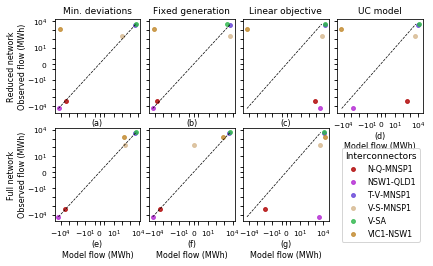

In [21]:
# Assign colour to each interconector
intercon_colour = {'N-Q-MNSP1': '#af0000', 'NSW1-QLD1': '#b326d3', 'T-V-MNSP1': '#6441d8', 'V-SA': '#2db74b', 'VIC1-NSW1': '#c1872a', 'V-S-MNSP1': '#d6b88f'}
df_iflow['colour'] = df_iflow.apply(lambda x: intercon_colour[x.name], axis=1)

# Create figure
fig = plt.figure()

def plot_flow_subplots(ax, scenario):
    "Plot interconnector flow subplots"
    
    for index, row in df_iflow.iterrows():
        ax.scatter(x=row[scenario], y=row['observed'], s=15, label=index, c=row['colour'], alpha=0.8)
        
    # Draw straight line
    min_val = df_iflow['observed'].min()
    max_val = df_iflow['observed'].max()
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=0.7)
    
    ax.set_yscale('symlog')
    ax.set_xscale('symlog')

# Remove unnecessary tick labels 
def format_tick_labels(tick_labels, turn_off_labels=False):
    "Format tick labels when using symmetric log scale"

    # Ticklables to keep
    keep_labels = ['$\\mathdefault{-10^{4}}$', '$\\mathdefault{-10^{1}}$', '$\\mathdefault{0}$', '$\\mathdefault{10^{1}}$', '$\\mathdefault{10^{4}}$']

    for tick_label in tick_labels:
        if '10^{0}' in tick_label.get_text():
            tick_label.set_text('0')

        tick_label.set_fontsize(7.5)
        if tick_label.get_text() not in keep_labels:
            tick_label.set_visible(False)
        
        if turn_off_labels:
            tick_label.set_visible(False)
        
# Create axes
ax1 = plt.axes([0.12, 0.56, 0.20, 0.37]) # Reduced network min flow deviations
ax2 = plt.axes([0.34, 0.56, 0.20, 0.37]) # Reduced network fixed gen
ax3 = plt.axes([0.56, 0.56, 0.20, 0.37]) # Reduced network free gen
ax4 = plt.axes([0.78, 0.56, 0.20, 0.37]) # Reduced network UC formulation

ax5 = plt.axes([0.12, 0.13, 0.20, 0.37]) # Full network min flow deviation
ax6 = plt.axes([0.34, 0.13, 0.20, 0.37]) # Full network fixed gen
ax7 = plt.axes([0.56, 0.13, 0.20, 0.37]) # Full network free gen

#          Min flow deviations, Fix gen output, var gen output (lin cost), var gen output (non-lin cost)
# Reduced          ax1,              ax2,             ax3,                          ax4
# Full             ax5,              ax6,             ax7

# Rough figures
plot_flow_subplots(ax1, 'dcopf_reduced_network_flow_gen_dev_min')    
plot_flow_subplots(ax2, 'dcopf_reduced_network_fixed_gen')   
plot_flow_subplots(ax3, 'dcopf_reduced_network_free_gen')   
plot_flow_subplots(ax4, 'uc')   

plot_flow_subplots(ax5, 'dcopf_full_network_flow_gen_dev_min')  
plot_flow_subplots(ax6, 'dcopf_full_network_fixed_gen')
plot_flow_subplots(ax7, 'dcopf_full_network_free_gen')  

# Draw canvas to expose ticks
fig.canvas.draw()        

# Turn off selected x tick labels
for ax in [ax1, ax2, ax3]:
    format_tick_labels(ax.get_xticklabels(), turn_off_labels=True)
    
# Turn off selelected y tick labels
for ax in [ax2, ax3, ax4, ax6, ax7]:
    format_tick_labels(ax.get_yticklabels(), turn_off_labels=True)

# Format xtick labels
for ax in [ax4, ax5, ax6, ax7]:
    format_tick_labels(ax.get_xticklabels())
    
# Format ytick labels
for ax in [ax1, ax5]:
    format_tick_labels(ax.get_yticklabels())
    
# Share axes
ax1.get_shared_y_axes().join(ax1, ax2)
ax1.get_shared_y_axes().join(ax1, ax3)
ax4.get_shared_y_axes().join(ax4, ax1)

ax5.get_shared_x_axes().join(ax5, ax1)
ax6.get_shared_x_axes().join(ax6, ax2)
ax7.get_shared_x_axes().join(ax7, ax3)

# Legend
leg = ax7.legend(bbox_to_anchor=(1.15, 0.78), loc=2, borderaxespad=0., fontsize=8)
leg.set_title('Interconnectors', prop={'size': 9})

# Titles
ax1.set_title('Min. deviations', fontsize=9)
ax2.set_title('Fixed generation', fontsize=9)
ax3.set_title('Linear objective', fontsize=9)
ax4.set_title('UC model', fontsize=9)

# xlabels
ax1.set_xlabel('(a)', fontsize=8, labelpad=0)
ax2.set_xlabel('(b)', fontsize=8, labelpad=0)
ax3.set_xlabel('(c)', fontsize=8, labelpad=0)

ax4.set_xlabel('(d)\nModel flow (MWh)', fontsize=8, labelpad=0)
ax5.set_xlabel('(e)\nModel flow (MWh)', fontsize=8, labelpad=0)
ax6.set_xlabel('(f)\nModel flow (MWh)', fontsize=8, labelpad=0)
ax7.set_xlabel('(g)\nModel flow (MWh)', fontsize=8, labelpad=0)

# ylabels
ax1.set_ylabel('Reduced network\nObserved flow (MWh)', fontsize=8, labelpad=0)
ax5.set_ylabel('Full network\nObserved flow (MWh)', fontsize=8, labelpad=0)

# Set figure size
width = 5.95114
height = width / 1.7
fig.set_size_inches(width, height)
fig.savefig(os.path.join(paths.output_dir, 'figures', 'aggregate_interconnector_flow_scenarios.pdf'))

## Miscellaneous plots
### Dispatch profiles
Plot dispatch profiles from linear DCOPF and UC model with temporal constraints. Compare output from these models to observed output.

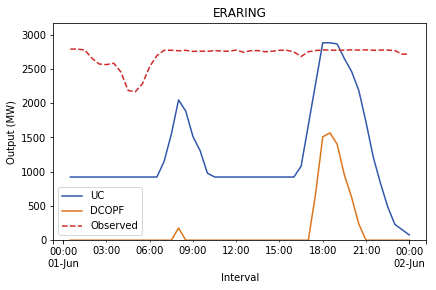

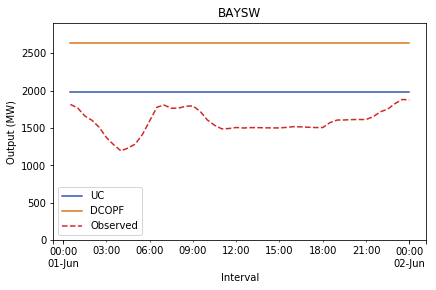

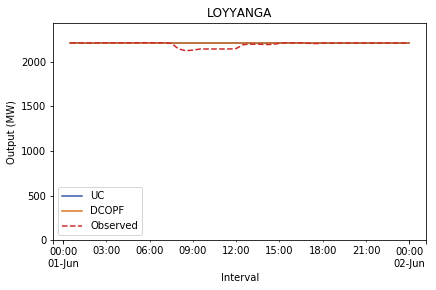

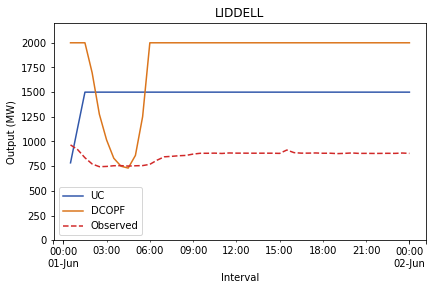

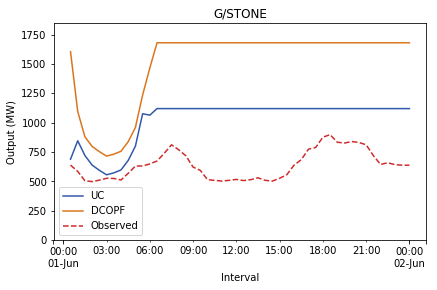

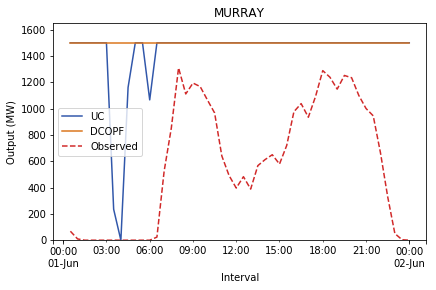

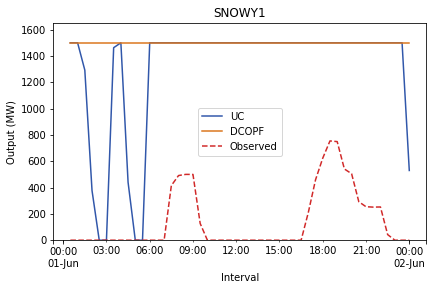

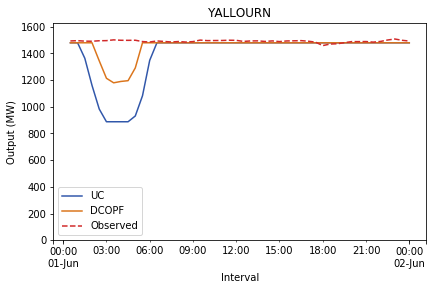

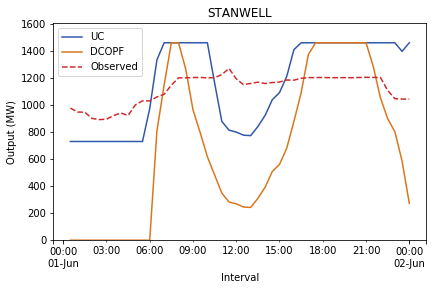

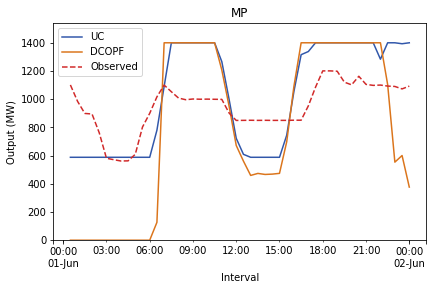

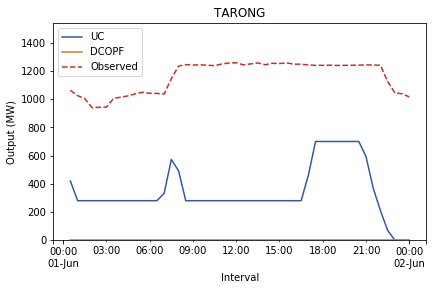

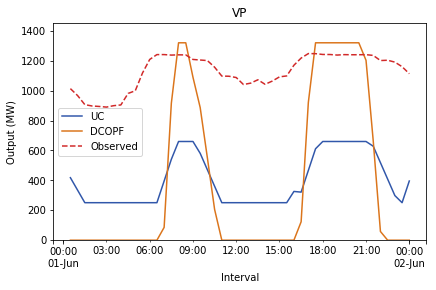

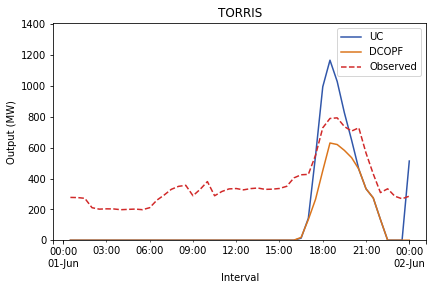

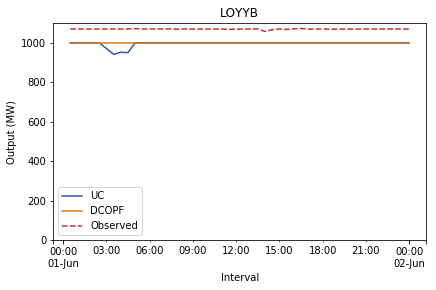

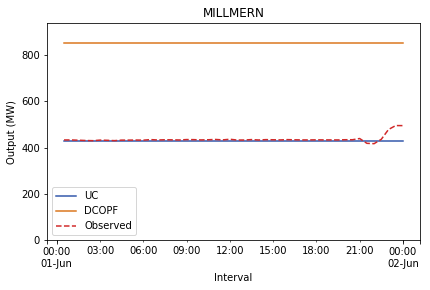

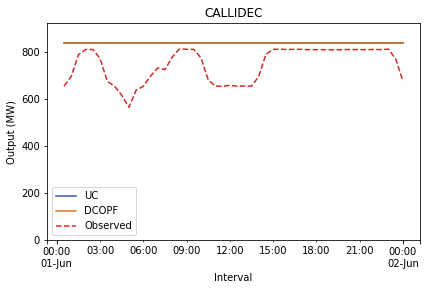

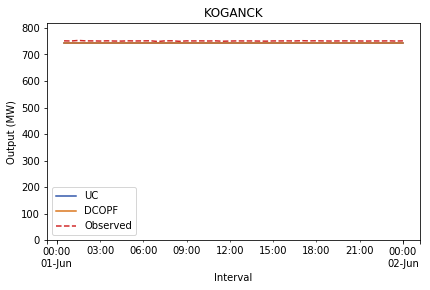

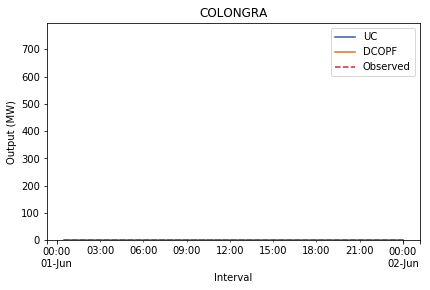

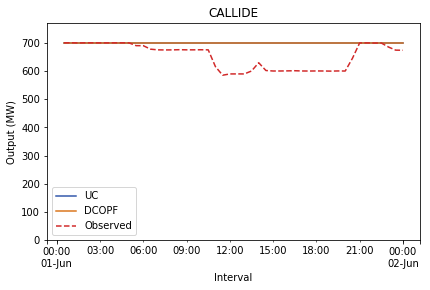

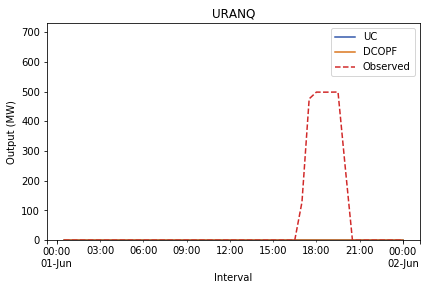

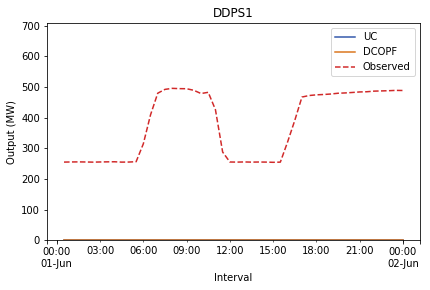

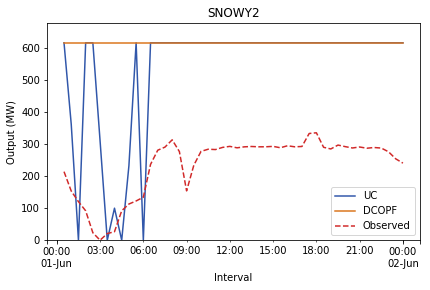

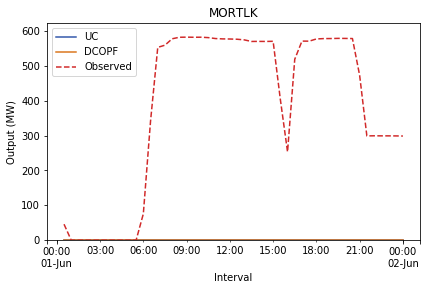

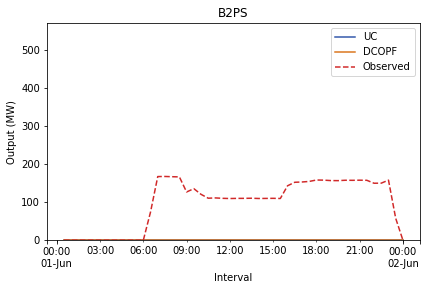

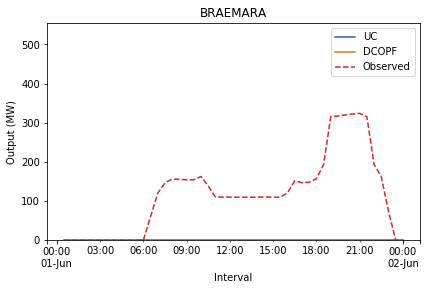

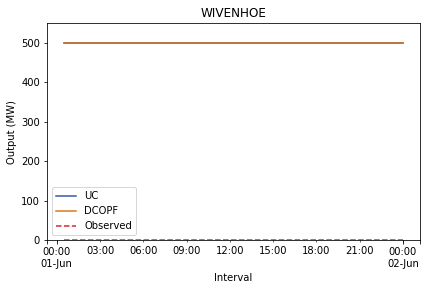

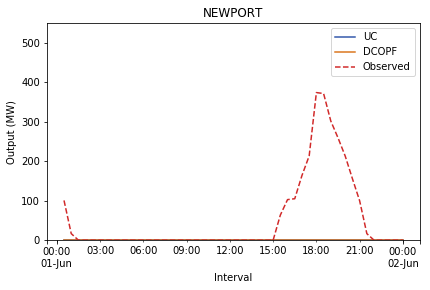

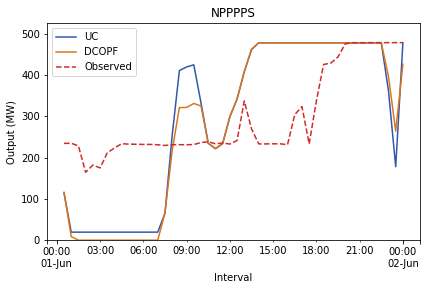

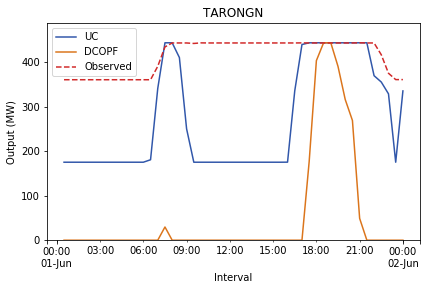

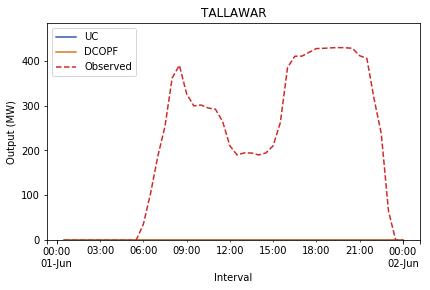

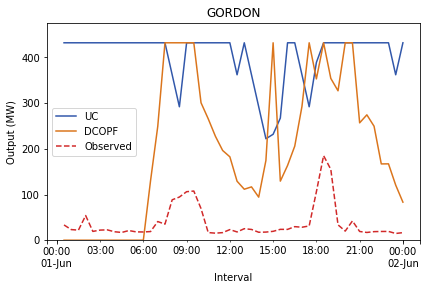

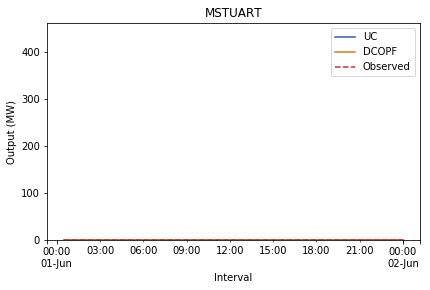

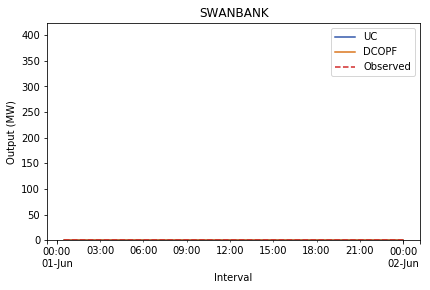

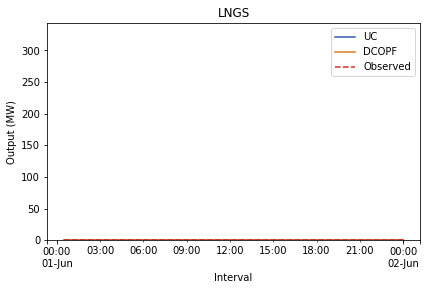

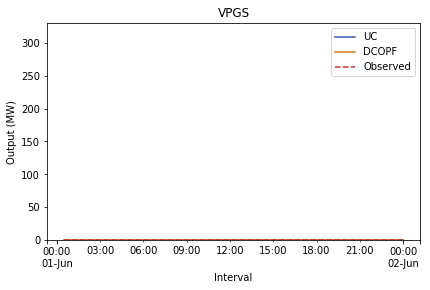

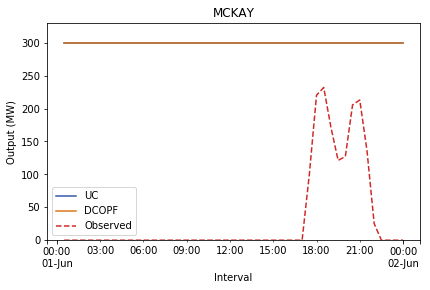

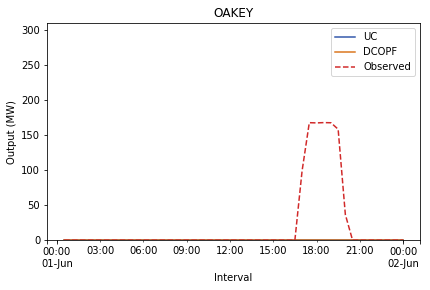

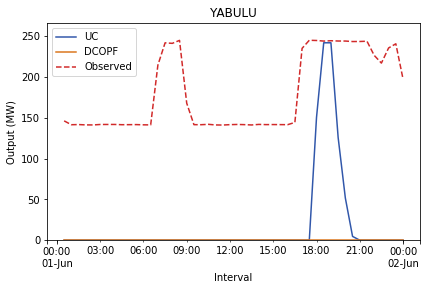

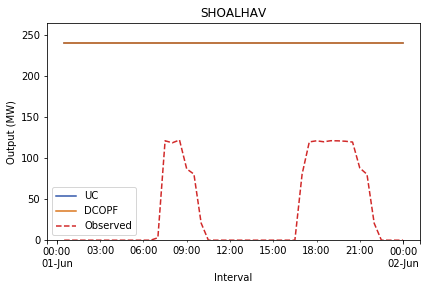

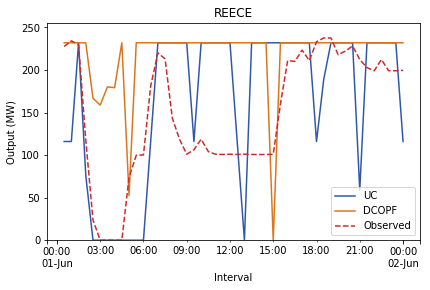

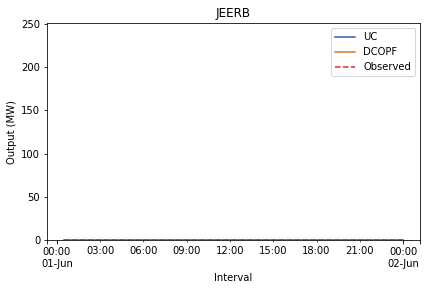

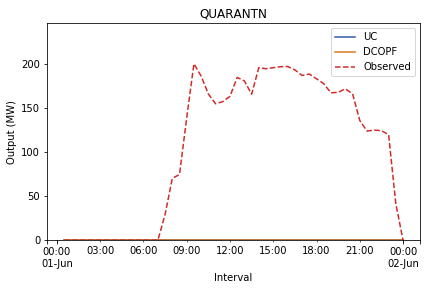

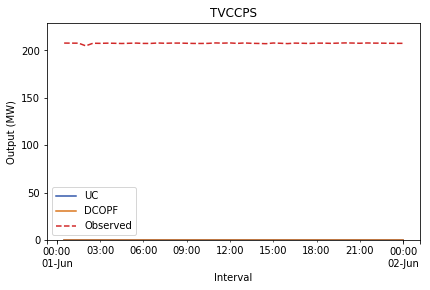

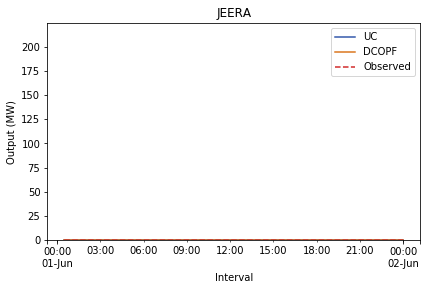

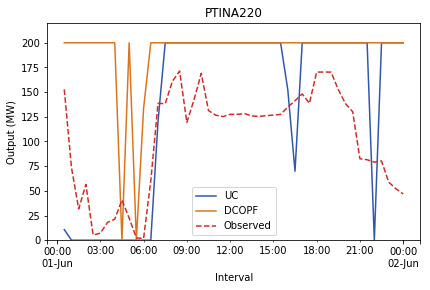

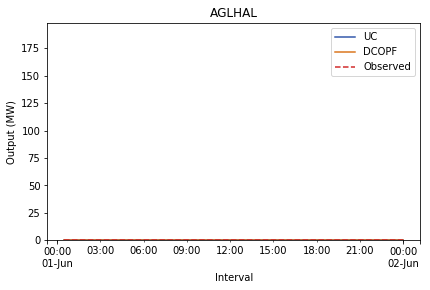

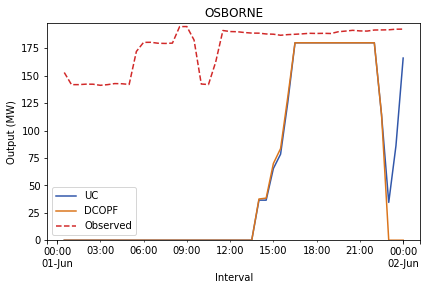

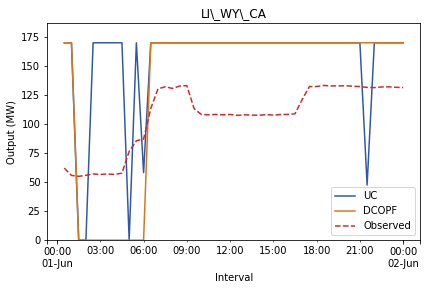

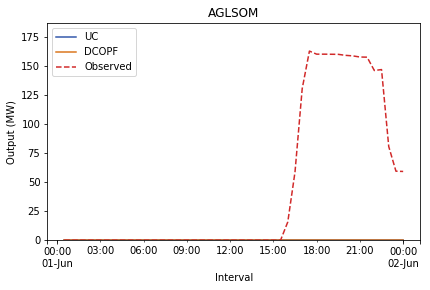

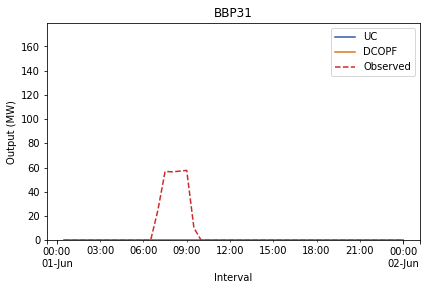

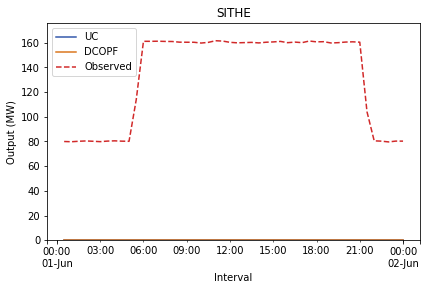

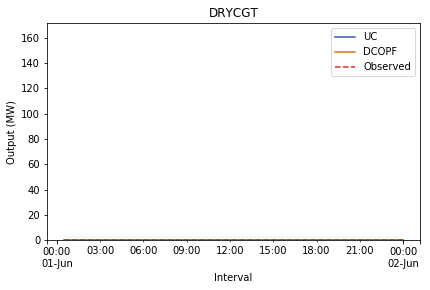

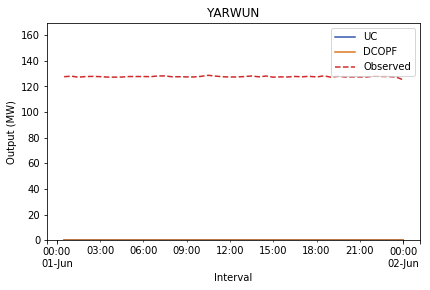

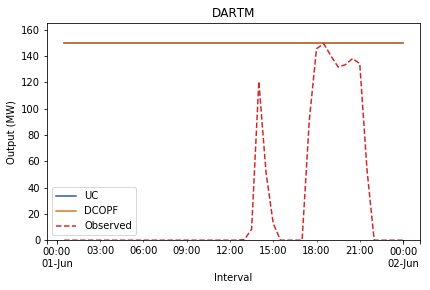

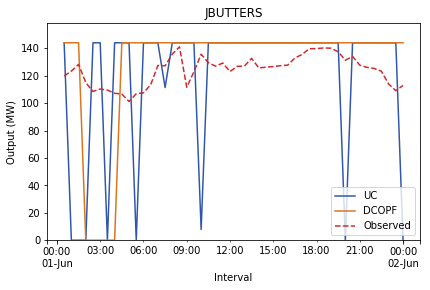

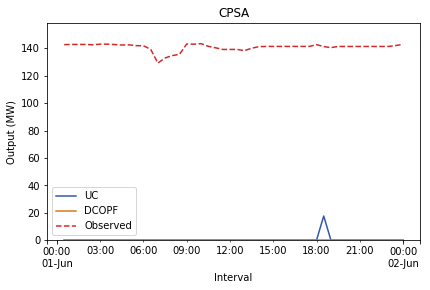

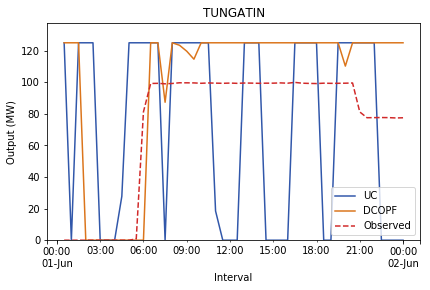

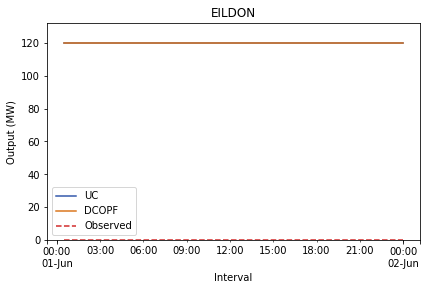

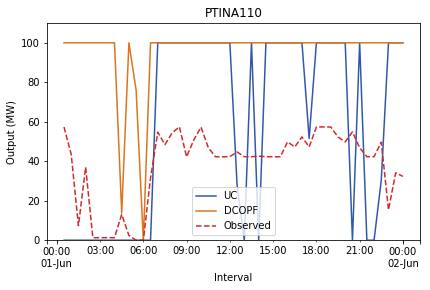

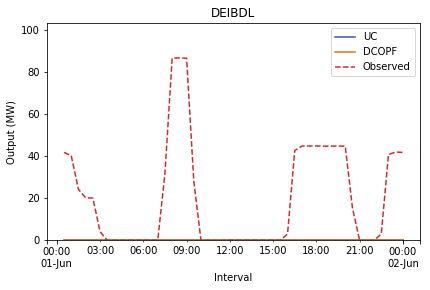

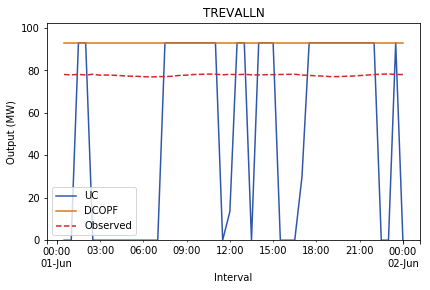

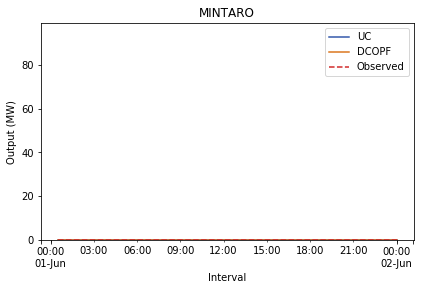

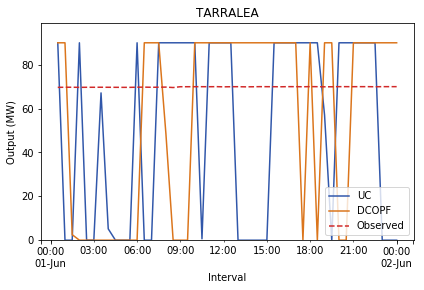

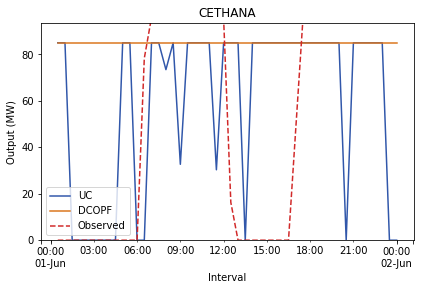

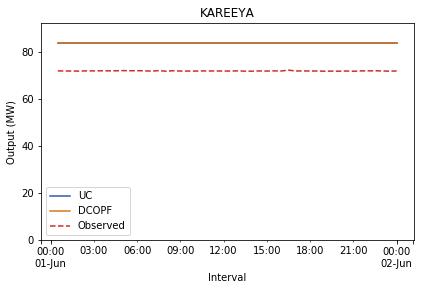

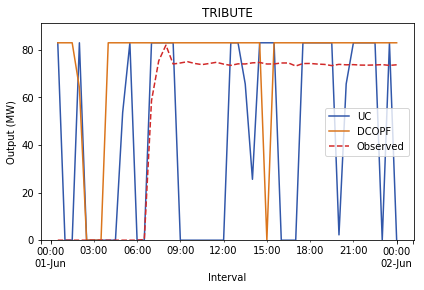

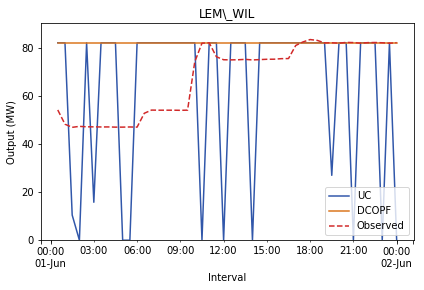

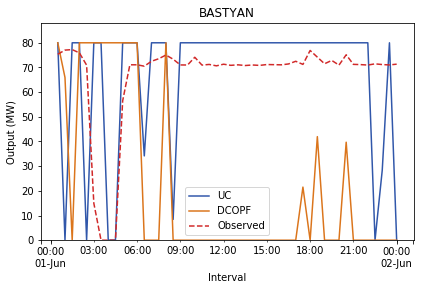

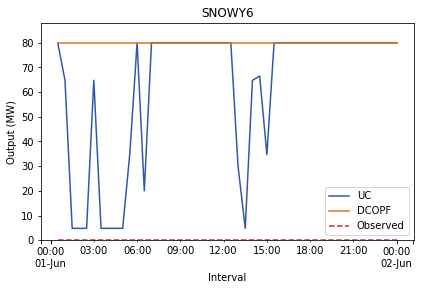

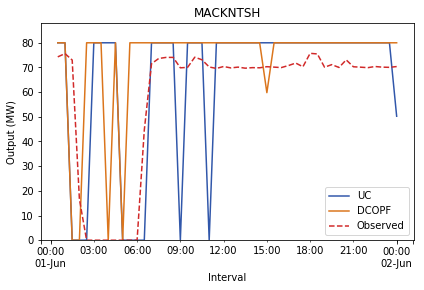

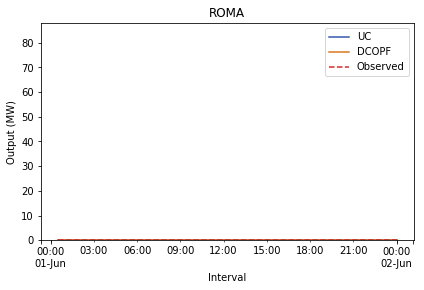

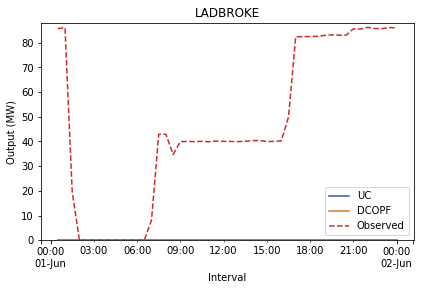

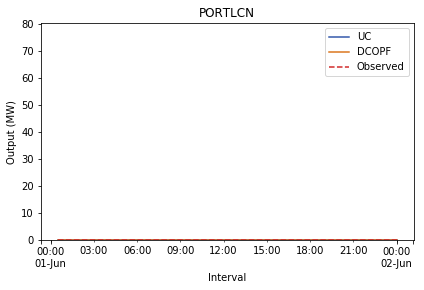

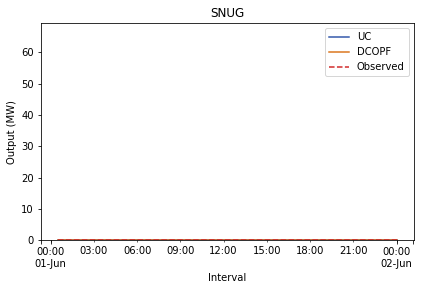

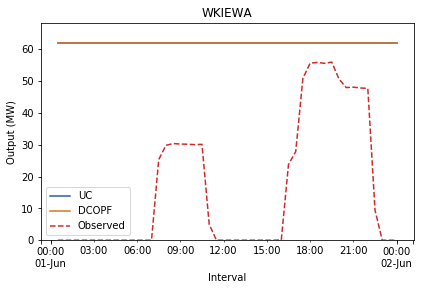

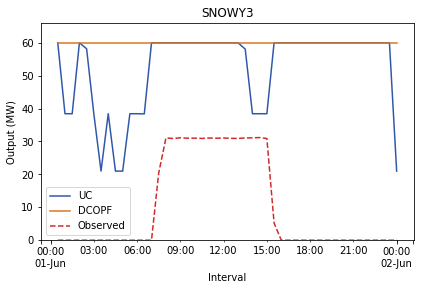

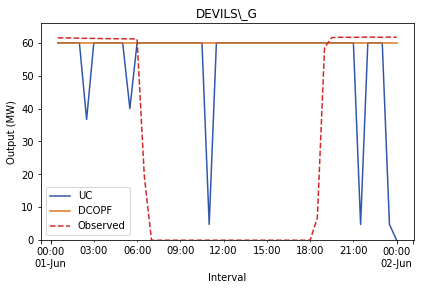

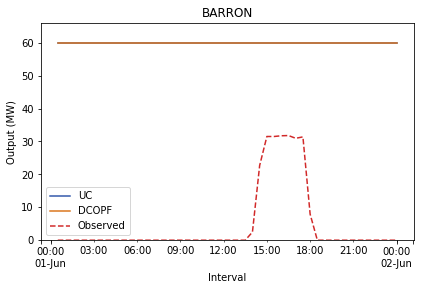

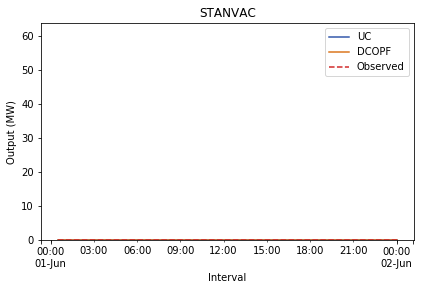

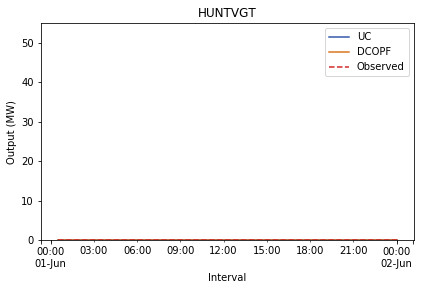

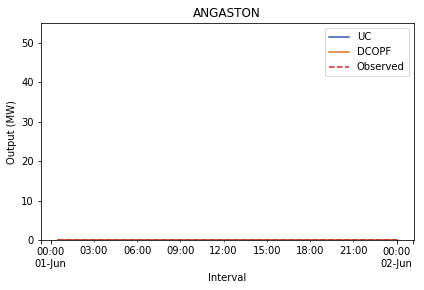

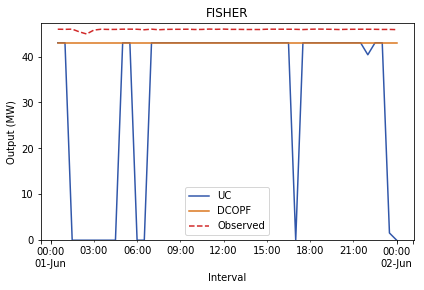

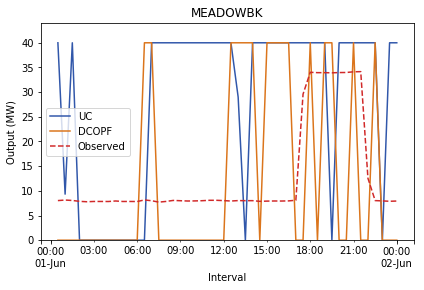

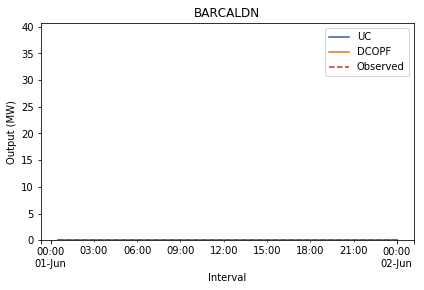

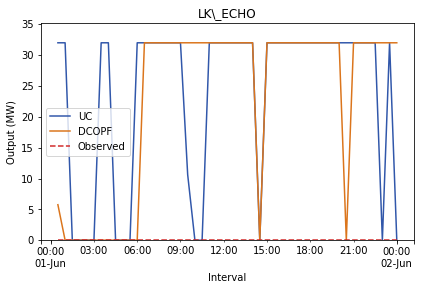

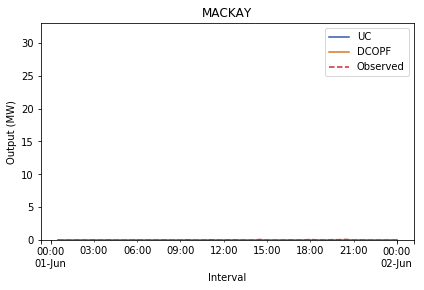

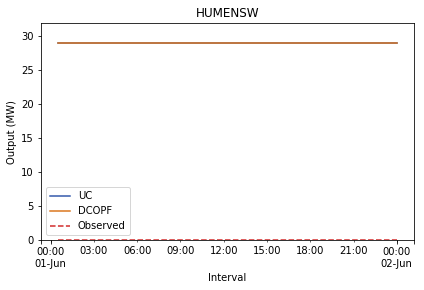

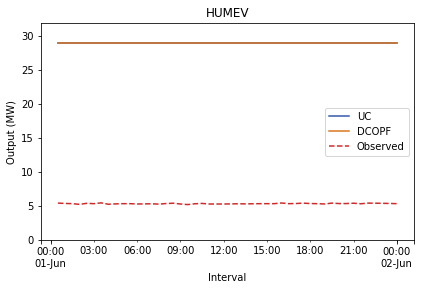

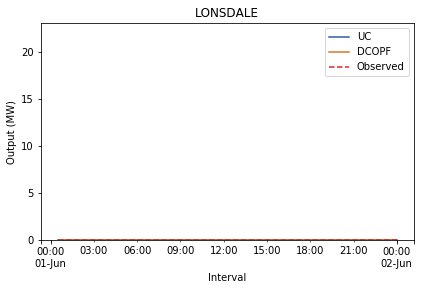

In [22]:
def plot_dispatch_profiles(station_id, data_obj, uc_obj, dcopf_obj):
    "Plot DCOPF, UC, and observed dispatch on same figure"
    
    # Time index
    t_index = uc_obj.get_model_station_dispatch_profile(station_id).index

    # UC model dispatch
    ax = uc_obj.get_model_station_dispatch_profile(station_id).plot(color='#3157aa')

    # DCOPF model dispatch
    dcopf_obj.get_model_station_dispatch_profile(station_id).plot(ax=ax, color='#db751c')

    # Observed dispatch
    data_obj.get_observed_station_dispatch_profile(station_id, t_index).plot(ax=ax, color='#d12929', style='--')

    # Max station capacity
    station_maxcap = network_data.df_g.groupby('STATIONID')['REG_CAP'].sum().loc[station_id]

    # Format axes
    ax.set_xlabel('Interval')
    ax.set_ylabel('Output (MW)')
    ax.set_ylim(0, station_maxcap * 1.1)
    plt.title(station_id.replace('_','\_'))
    plt.legend(['UC', 'DCOPF', 'Observed'])
    fig = ax.get_figure()
    fig.subplots_adjust(left=.11, bottom=.16, right=.98, top=.98)
    width = 5.95114
    height = width / 1.618
    fig.set_size_inches(width, height)
    file_name = ''.join(['station_dispatch_', station_id.replace('/', ''), '.pdf'])
    plt.savefig(os.path.join(paths.output_dir, 'figures', file_name))
    plt.show()   
    
for station_id in dcopf_full_network_free_gen.get_sorted_stations():
    plot_dispatch_profiles(station_id, model_data, uc, dcopf_full_network_free_gen)

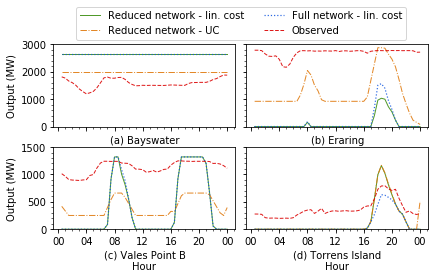

In [23]:
# Aggregate DUIDs to stations.
def agg_gens(row):
    return pd.Series({'REG_CAP': row['REG_CAP'].sum(), 'FUEL_CAT': list(set(row['FUEL_CAT']))[0]})
largest_gens = network_data.df_g.groupby('STATIONID')[['REG_CAP', 'FUEL_CAT']].agg(agg_gens).sort_values(by='REG_CAP', ascending=False).index[:4]

station_id = 'LIDDELL'
def plot_on_axis(station_id, ax):
    "Given a station ID, plot dispatch profiles obtained from different scenarios and observed output"
    
    model_dcopf_full_free_gen = dcopf_full_network_free_gen.get_model_station_dispatch_profile(station_id)
    model_dcopf_redu_free_gen = dcopf_reduced_network_free_gen.get_model_station_dispatch_profile(station_id)
    uc_redu_free_gen = uc.get_model_station_dispatch_profile(station_id)
    observed = model_data.df_scada.T.join(network_data.df_g[['STATIONID']], how='left').groupby('STATIONID').sum().T.loc[model_dcopf_full_free_gen.index, station_id]

    ax.plot(model_dcopf_redu_free_gen, label='Reduced network - lin. cost', color='#3e8e13', alpha=0.9, linewidth=1)
    ax.plot(uc_redu_free_gen, label='Reduced network - UC', alpha=0.9, color='#e07b10', linewidth=1, linestyle='-.')
    ax.plot(model_dcopf_full_free_gen, label='Full network - lin. cost', color='#1156e0', alpha=0.9, linewidth=1.2, linestyle=':')
    ax.plot(observed, label='Observed', alpha=0.9, linewidth=1, color='#db0202', linestyle='--')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)

plot_on_axis('BAYSW', ax1)
plot_on_axis('ERARING', ax2)
plot_on_axis('VP', ax3)
plot_on_axis('TORRIS', ax4)

ax4.legend(ncol=2, loc='upper center', bbox_to_anchor=(-0.03, 2.77), fontsize=10)
ax1.set_ylim([0, 3000])
ax2.set_ylim([0, 3000])
ax3.set_ylim([0, 1500])
ax4.set_ylim([0, 1500])


# Format the ticks
# ----------------
# y-axis
majorLocator = MultipleLocator(20)
majorFormatter = FormatStrFormatter('%d')
minorLocator_top = MultipleLocator(200)
minorLocator_bottom = MultipleLocator(100)

# x-axis
minutes = mdates.MinuteLocator([0])
minutesFmt = mdates.DateFormatter('%M')

hours = mdates.HourLocator(range(0, 23, 4))
hoursFmt = mdates.DateFormatter('%H')

days = mdates.DayLocator()
daysFmt = mdates.DateFormatter('%d %b')

months = mdates.MonthLocator()
monthsFmt = mdates.DateFormatter('%b')

# Format minor ticks
for ax in [ax1, ax2]:
    ax.yaxis.set_minor_locator(minorLocator_top)
      
for ax in [ax3, ax4]:
    ax.yaxis.set_minor_locator(minorLocator_bottom)

for ax in [ax1, ax2, ax3, ax4]:
    ax.xaxis.set_major_locator(hours)
    ax.xaxis.set_major_formatter(hoursFmt)
    
    ax.xaxis.set_minor_locator(minutes)
    
ax1.set_ylabel('Output (MW)')
ax3.set_ylabel('Output (MW)')

ax3.set_xlabel('Hour')
ax4.set_xlabel('Hour')

# Turn off y-labels
for ax in [ax2, ax4]:
    for i in ax.get_yticklabels():
        i.set_visible(False)

# Turn off x-labels
for ax in [ax1, ax2]:
    for i in ax.get_xticklabels():
        i.set_visible(False)

ax1.set_xlabel('(a) Bayswater')
ax2.set_xlabel('(b) Eraring')
ax3.set_xlabel('(c) Vales Point B\nHour')
ax4.set_xlabel('(d) Torrens Island\nHour')

fig.subplots_adjust(wspace=0.06, hspace=0.25)

# Format axes
width = 5.95114
height = width / 1.6
fig.set_size_inches(width, height)
fig.subplots_adjust(left=0.115, bottom=0.16, right=0.99, top=0.85)
fig.savefig(os.path.join(paths.output_dir, 'figures', 'dispatch_profile_comparison.pdf'))

### Power-flow
Power-flows over lines at 4pm on 1 June 2017.

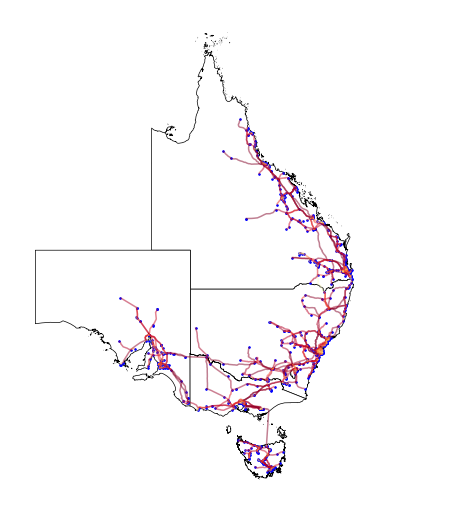

In [24]:
def plot_dcopf_power_flow(gdf_l, dcopf_obj):
    "Plot powerflows over lines for full-network DCOPF results"
    
    # Load DCOPF data
    df_dcopf = dcopf_obj.parse_dcopf_results()
    
    # Time index for power flow plots
    t = pd.Timestamp('2017-06-01 16:00:00')
    gdf_l = pd.merge(gdf_l, df_dcopf.loc[df_dcopf['SET_NAME'] == 'v', [t, 'VAR_NAME']].set_index('VAR_NAME'), how='left', left_on='FROM_NODE', right_index=True).rename(columns={t:'FROM_NODE_ANGLE'})
    gdf_l = pd.merge(gdf_l, df_dcopf.loc[df_dcopf['SET_NAME'] == 'v', [t, 'VAR_NAME']].set_index('VAR_NAME'), how='left', left_on='TO_NODE', right_index=True).rename(columns={t:'TO_NODE_ANGLE'})

    # Compute power flow over each line
    gdf_l['POWER_FLOW'] = abs(100 * np.imag(gdf_l['LINE_LENGTH_KM'] * gdf_l['Z_PU']) * (gdf_l['FROM_NODE_ANGLE'] - gdf_l['TO_NODE_ANGLE']))

    for index, row in dcopf_obj.df_hvdc.iterrows():
        # HVDC nodes
        fn, tn = dcopf_obj.df_hvdc.loc[index, 'FROM_NODE'], dcopf_obj.df_hvdc.loc[index, 'TO_NODE']
        mask_lines = gdf_l['FROM_NODE'].isin([fn, tn]) & gdf_l['TO_NODE'].isin([fn, tn])

        # Update powerflow
        mask_power_flow = (df_dcopf['SET_NAME'] == 'h') & (df_dcopf['VAR_NAME'] == index)
        
        gdf_l.loc[mask_lines, 'POWER_FLOW'] = abs(df_dcopf.loc[mask_power_flow, t].values[0])

    plt.clf()
    # Plot state boundaries
    ax = network_data.gdf_states.set_index('STATE_NAME').drop(['Northern Territory', 'Other Territories', 'Western Australia']).plot(color='white', edgecolor='black', linewidth=0.7)

    # Plot lines
    kw = dict(column='POWER_FLOW', k=1000, cmap='YlOrRd')
    mask = network_data.gdf_l['IS_HVDC'] | network_data.gdf_l['CONNECTED']  
    gdf_l.loc[mask, ['geometry', 'POWER_FLOW']].plot(ax=ax, alpha=0.5, scheme='QUANTILES', **kw)
    
    # Plot nodes
    network_data.gdf_n.loc[network_data.gdf_n['CONNECTED'] == True].plot(ax=ax, markersize=2.5, color='blue')

    # Format axes
    ax.set_axis_off()
    ax.set_xlim(129, 155)
    fig = ax.get_figure()
    fig.subplots_adjust(left=0.02, bottom=0, right=1, top=1)
    width = 5.95114 * 0.8
    height = width * 1.5
    fig.set_size_inches(width, height)

    # Save figure
    fig.savefig(os.path.join(paths.output_dir, 'figures', 'dcopf_line_flow_nominal.pdf'))
    plt.show()
    return ax
ax = plot_dcopf_power_flow(network_data.gdf_l, dcopf_full_network_free_gen)

## References
[1] - Australian Energy Markets Operator. Data Archive (2018). at http://www.nemweb.com.au/#mms-data-model